In [2]:
library(data.table)
library(biomaRt)
library(ggplot2)
library(rstatix)
library(ggpubr)
human <- useMart("ensembl", dataset="hsapiens_gene_ensembl")


Attaching package: ‘rstatix’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:stats’:

    filter




In [3]:
wound_files <-list.files('./wound_genes/')
grep("^GSE.*up", wound_files)
wound_files <- wound_files[grep("^GSE.*up", wound_files)]

[1] 716 718 720 722 724 726 728 730 732 734 736 738 740 742 744 746 748 750
 [19] 752 754 756 758 760 762 764 766 768 770 772 774 776 778 780 782 784 786
 [37] 788 790 792 794 796 798 800 802 804 806 808 810 812 814 816 818 820 822
 [55] 824 826 828 830 832 834 836 838 840 842 844 846 848 850 852 854 856 858
 [73] 860 862 864 866 868 870 872 874 876 878 880 882 884 886 888 890 892 894
 [91] 896 898 900 902 904 906 908 910 912 914 916 918 920 922 924 926 928 930
[109] 932 934 936 938 940 942 944 946 948 950 952

In [4]:
skin_logfc <- data.frame(fread("skin_logfc.txt"))

Warning message in fread("skin_logfc.txt"):
“Detected 6 column names but the data has 7 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
get_lfc_boxplot <- function(gene_set, lfc, label){
    total_lfc <- lfc$log2FoldChange
    gene_list <- gene_set$gene
    ensembl_list <- getLDS(attributes=c("hgnc_symbol"), filters="hgnc_symbol",
                              values=gene_list,
                              mart=human,attributesL=c("ensembl_gene_id"),
                              martL=human)
    subset_lfc <- lfc[lfc$V1 %in% ensembl_list$Gene.stable.ID,]$log2FoldChange
    #print(head(subset_lfc))
    
    lfcDF <- data.frame("value" = c(total_lfc, subset_lfc),
                       "label" = c(rep("Total lfc", length(total_lfc)),
                                   rep(label, length(subset_lfc))))
    
    plot <- ggplot(lfcDF, aes(x = label, y = value)) +
      geom_boxplot() +
      stat_pvalue_manual(lfcDF %>% 
                           pairwise_wilcox_test(value ~ label) %>% 
                           add_xy_position())
    hist(gene_set$recurrence, breaks = 100)
    return(plot)
}

In [6]:
get_cross_species_data <- function(directory, regex, label){
    files <-list.files(directory)
    files <- files[grep(regex, files)]
    
    deg_num <- numeric(length(files))
    gene_list <- character(0)
    total_genes <- character(0)
    recurrent_genes <- list()
    for(i in 1:length(wound_files)) {
        if(is.na(files[i])) {next}
        current_file <- fread(paste(directory, files[i], sep=""), header=F)

        #print(head(current_file$V1))
        gene_list <- c(unique(append(gene_list, unique(current_file$V1), length(gene_list))))
        total_genes <- c(append(total_genes, unique(current_file$V1), length(total_genes)))
        deg_num[i] <- (length(unique(current_file$V1)))

    }

    for(i in 1:length(total_genes)) {
        if (!(total_genes[i] %in% names(recurrent_genes))) {
            recurrent_genes[[total_genes[i]]] <- 1
        } else {
            recurrent_genes[[total_genes[i]]] <- recurrent_genes[[total_genes[i]]] + 1
        }
    }

    print(paste("total genes = ", length(total_genes), sep = ""))
    print(paste("unique genes = ", length(gene_list), sep = ""))
    # histogram of the average number of upregulated genes
    hist(deg_num, breaks = 100)
    
    gene_recurrence <- data.frame("recurrence" = unlist(recurrent_genes), "gene" = names(recurrent_genes))
    total_recurrent <- list()
    total_recurrent[["5"]] <- gene_recurrence[order(gene_recurrence$recurrence, decreasing = T),][1:round(nrow(gene_recurrence)*.05),]
    total_recurrent[["10"]] <- gene_recurrence[order(gene_recurrence$recurrence, decreasing = T),][1:round(nrow(gene_recurrence)*.1),]
    total_recurrent[["25"]] <- gene_recurrence[order(gene_recurrence$recurrence, decreasing = T),][1:round(nrow(gene_recurrence)*.25),]
    total_recurrent[["50"]] <- gene_recurrence[order(gene_recurrence$recurrence, decreasing = T),][1:round(nrow(gene_recurrence)*.50),]
    
    write.table(total_recurrent[["5"]]$gene, file = paste(label,"_top5_reccurent.txt",sep=""), quote = F, sep = " ",
            row.names = F, col.names = F)
    write.table(total_recurrent[["10"]]$gene, file = paste(label,"_top10_reccurent.txt",sep=""), quote = F, sep = " ",
            row.names = F, col.names = F)
    write.table(total_recurrent[["25"]]$gene, file = paste(label,"_top25_reccurent.txt",sep=""), quote = F, sep = " ",
            row.names = F, col.names = F)
    write.table(total_recurrent[["50"]]$gene, file = paste(label,"_top50_reccurent.txt",sep=""), quote = F, sep = " ",
            row.names = F, col.names = F)
    
    return(total_recurrent)
}

[1] "total genes = 238879"
[1] "unique genes = 14108"


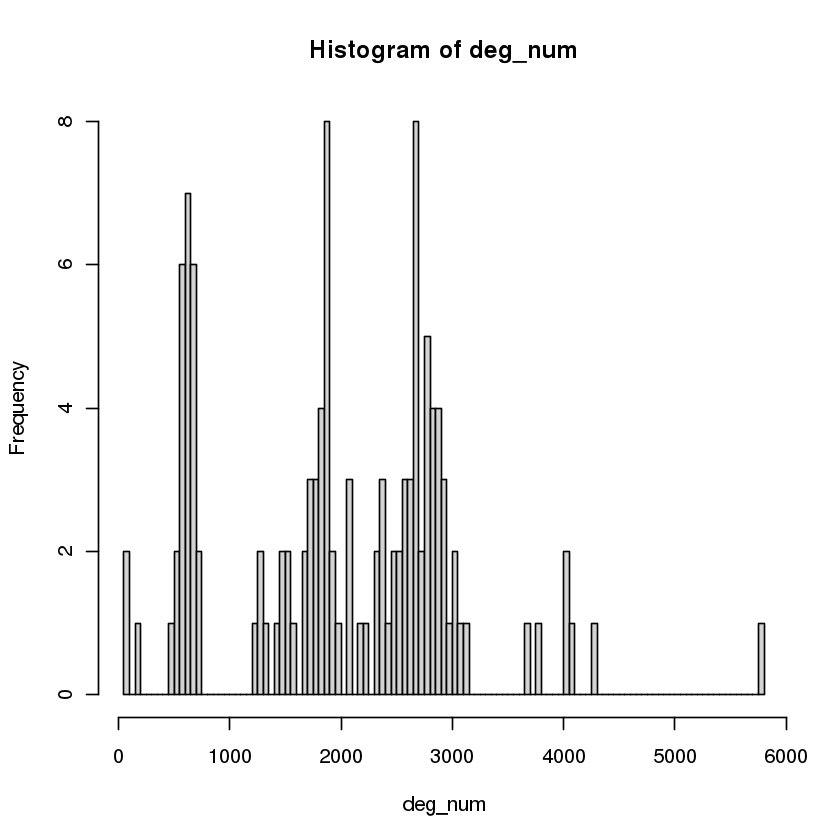

In [7]:
wound_recurrent <- get_cross_species_data('./wound_genes/', "^GSE.*up", "wound")

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


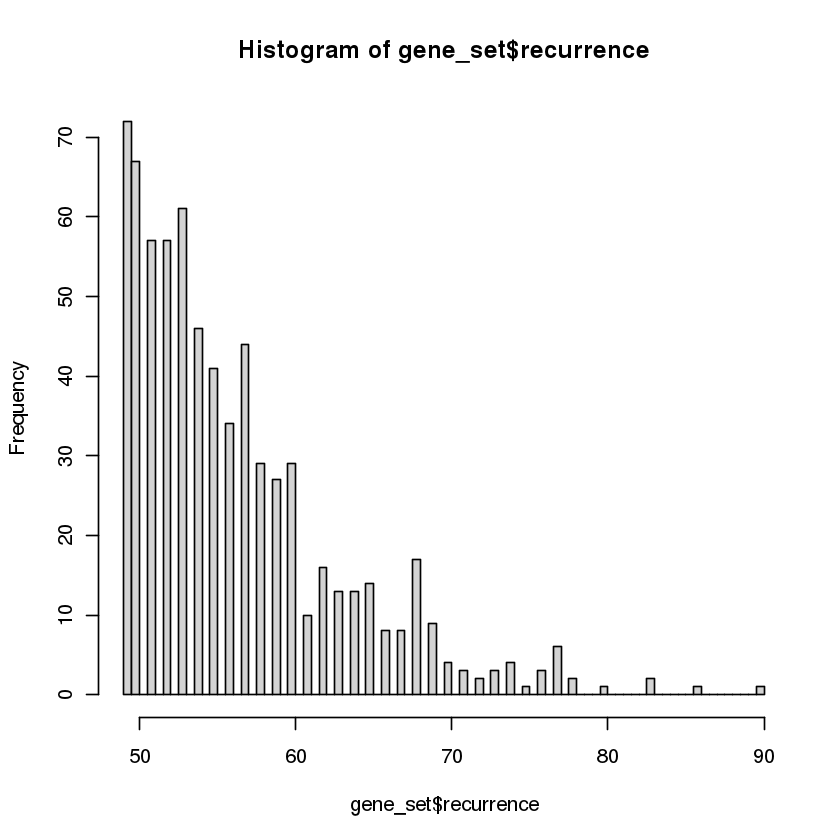

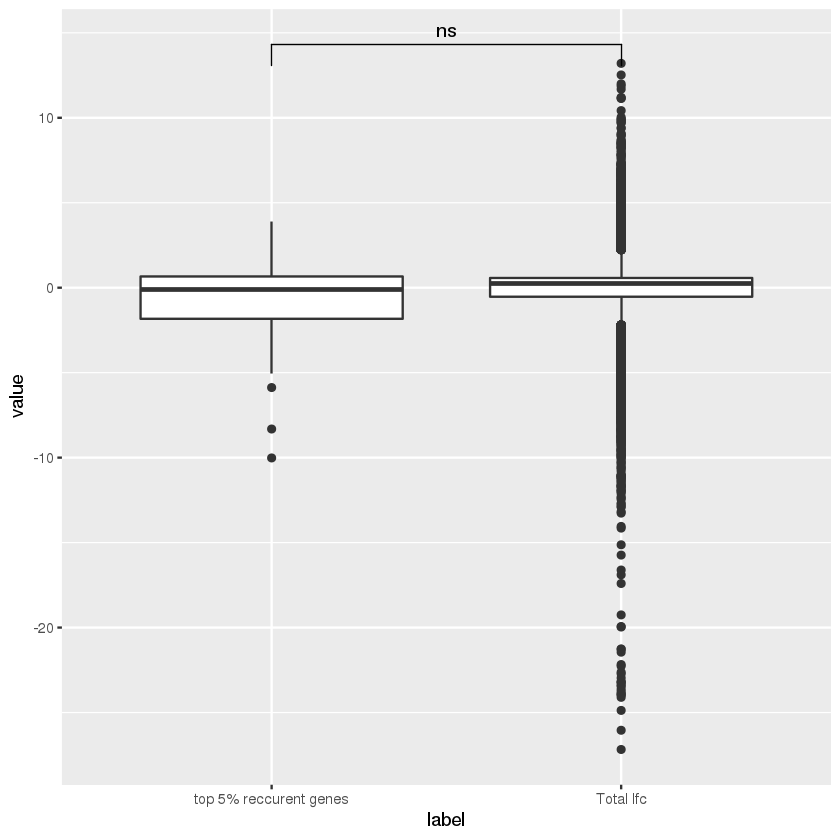

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


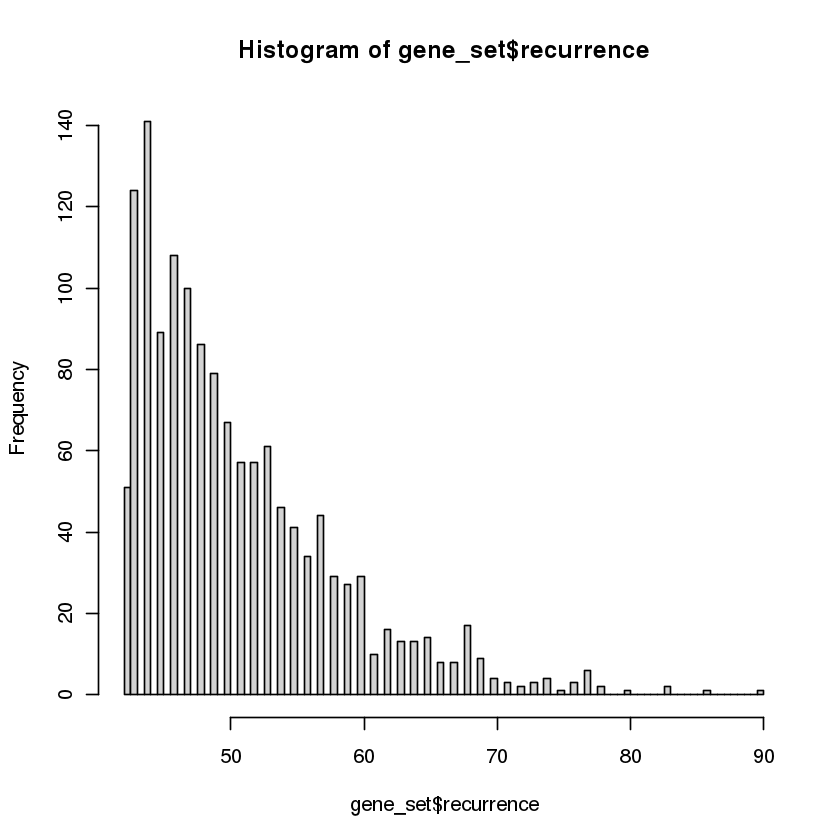

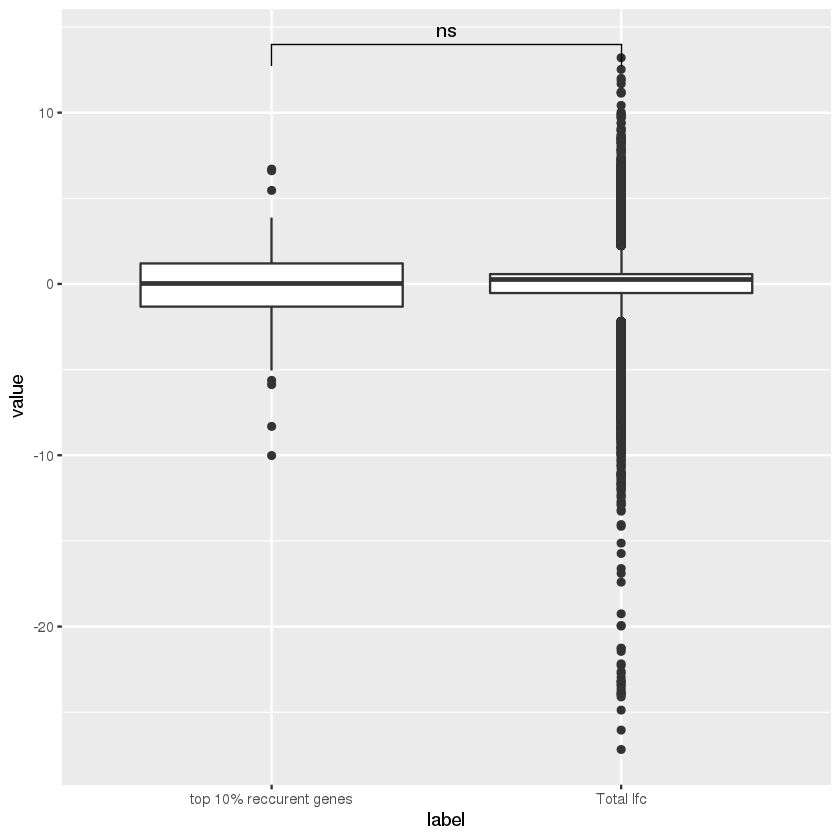

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


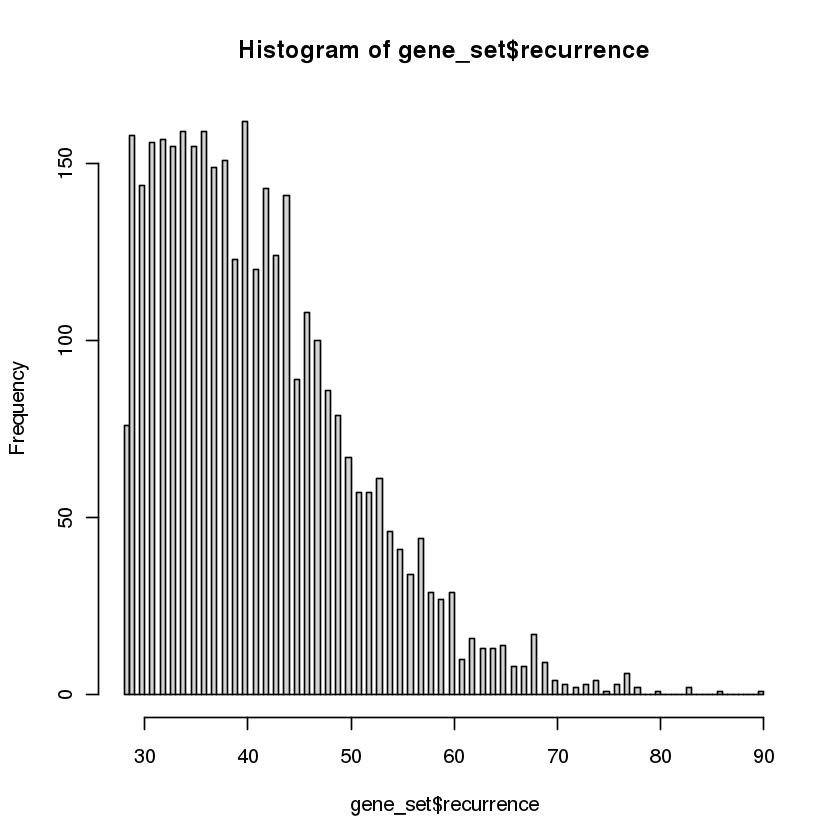

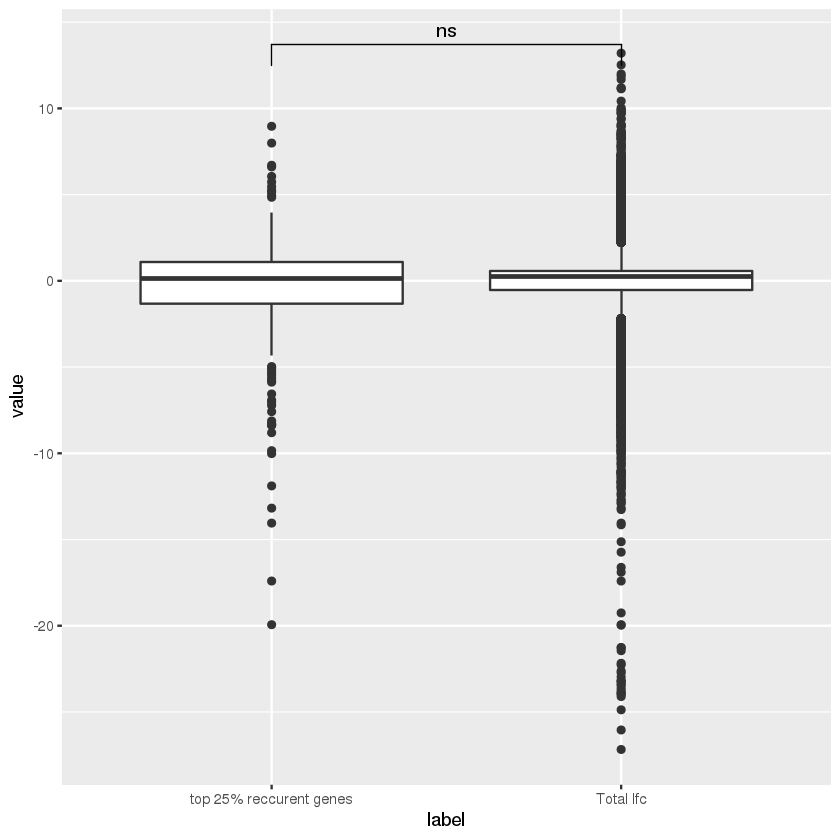

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


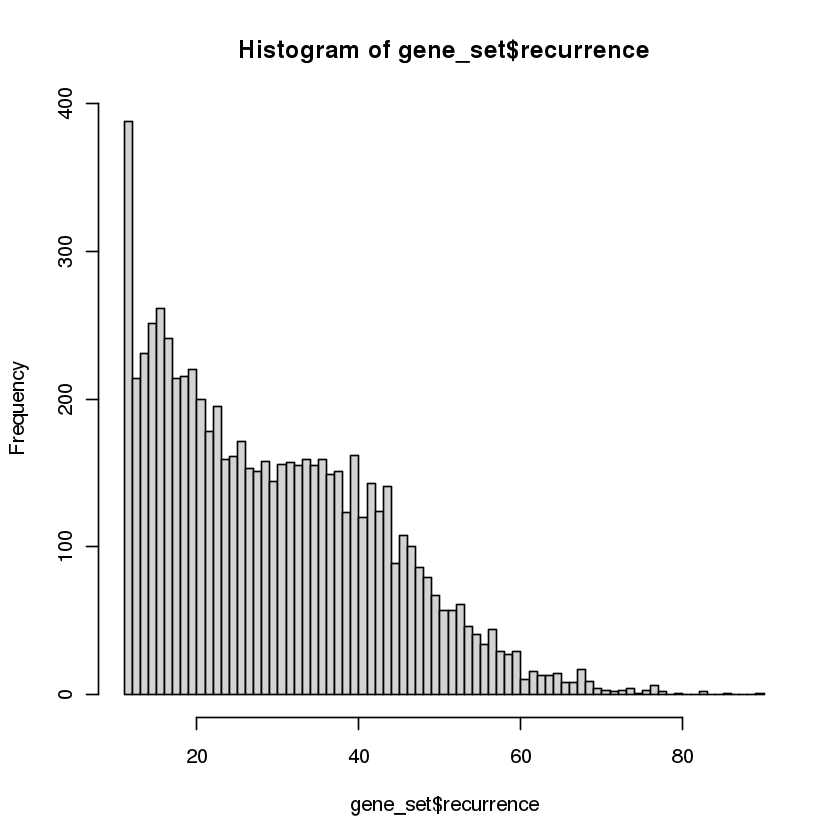

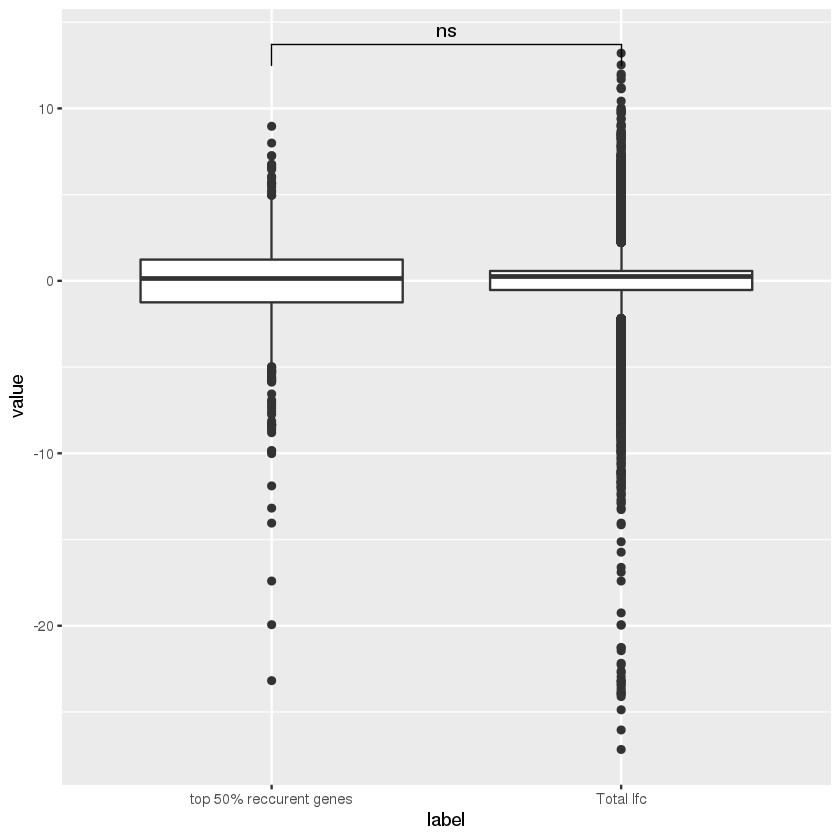

In [8]:
get_lfc_boxplot(wound_recurrent[["5"]],skin_logfc, "top 5% reccurent genes")
get_lfc_boxplot(wound_recurrent[["10"]],skin_logfc, "top 10% reccurent genes")
get_lfc_boxplot(wound_recurrent[["25"]],skin_logfc, "top 25% reccurent genes")
get_lfc_boxplot(wound_recurrent[["50"]],skin_logfc, "top 50% reccurent genes")

In [10]:
wound_recurrent[["5"]][1:10,]

,recurrence,gene
,<dbl>,<chr>
SLC2A4,90,SLC2A4
DNMT1,86,DNMT1
COL5A1,83,COL5A1
ATP9A,83,ATP9A
GUSB,80,GUSB
FBXO7,78,FBXO7
STAT5A,78,STAT5A
PEG3,77,PEG3
DDX39B,77,DDX39B


[1] "total genes = 340885"
[1] "unique genes = 17132"


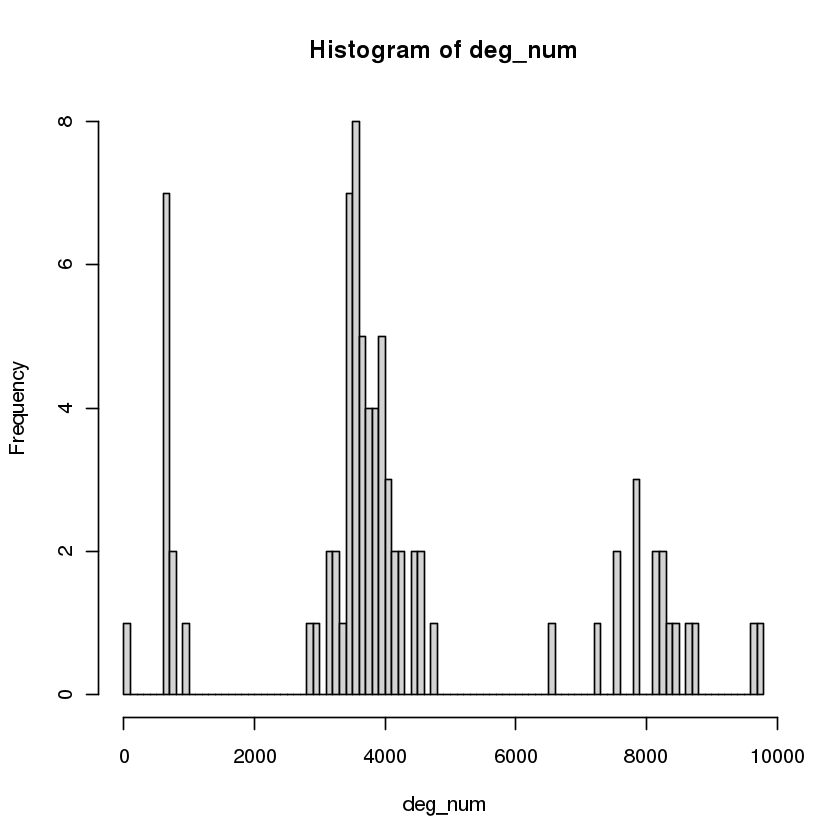

In [11]:
stress_recurrent <- get_cross_species_data('./stress_genes/', "^GSE.*up", "stress")

In [12]:
stress_recurrent[["5"]][1:10,]

,recurrence,gene
,<dbl>,<chr>
FBXL17,78,FBXL17
VRK1,77,VRK1
SKP2,76,SKP2
SLC2A1,76,SLC2A1
FBXL3,75,FBXL3
KMT2D,75,KMT2D
SETDB1,75,SETDB1
GLIPR1,74,GLIPR1
MFSD14A,74,MFSD14A


Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


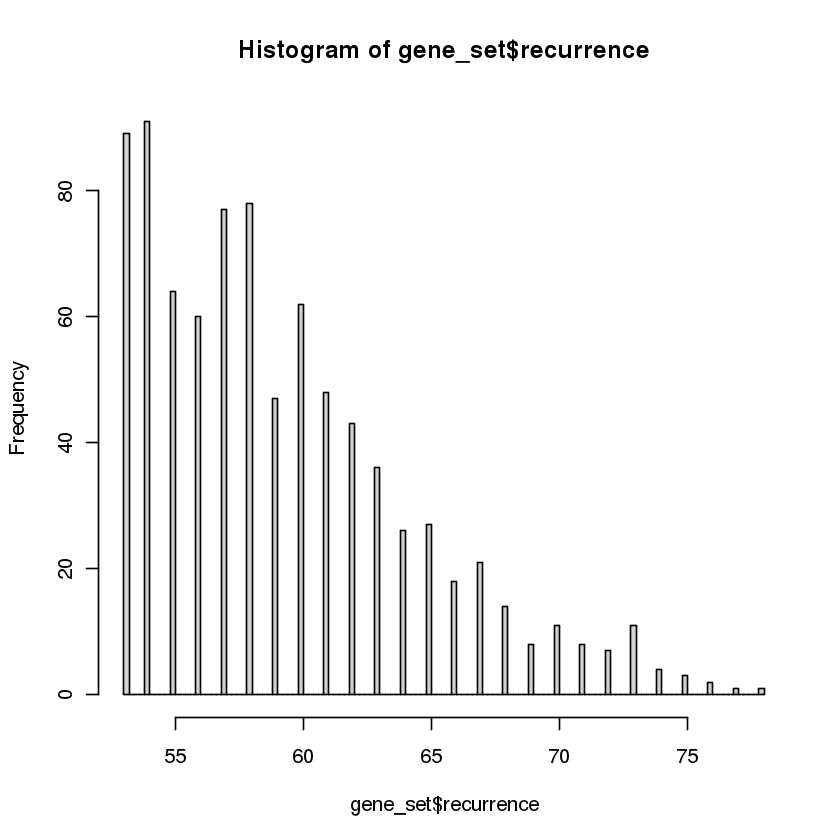

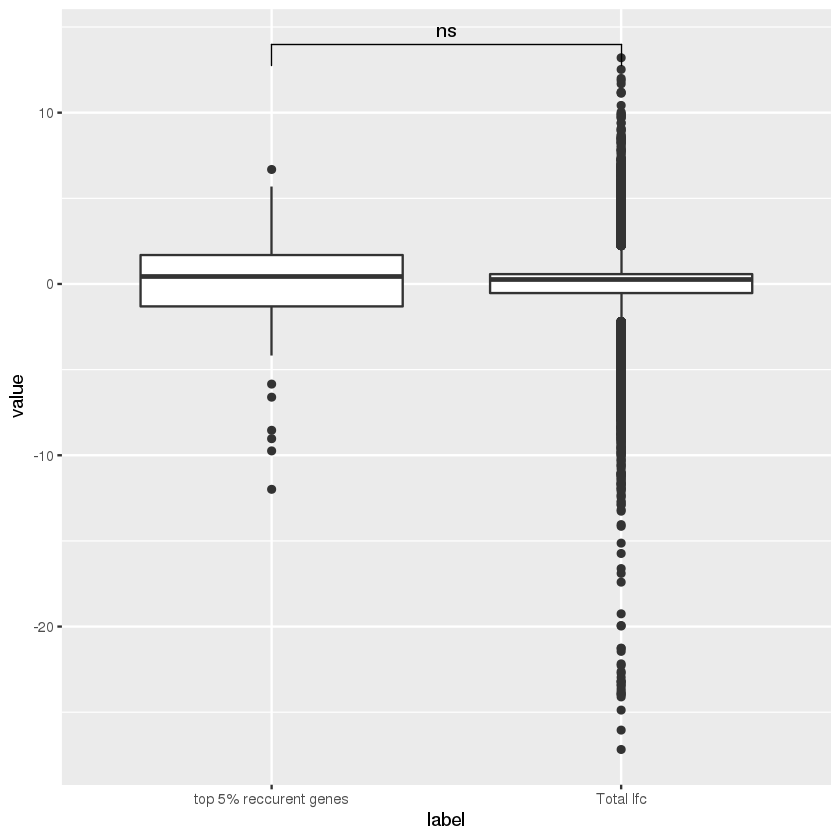

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


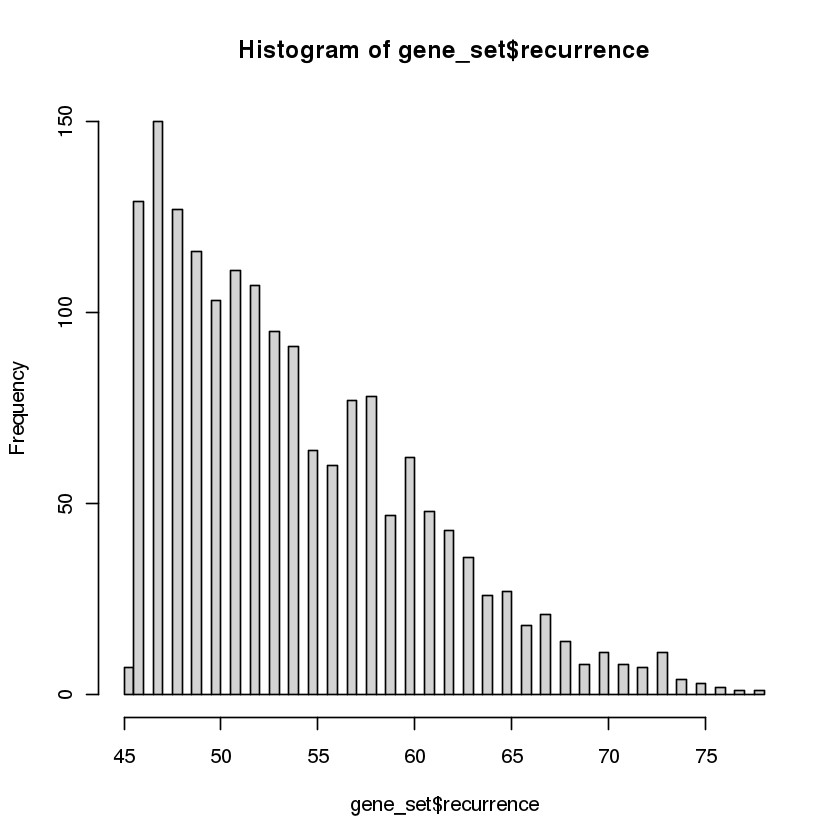

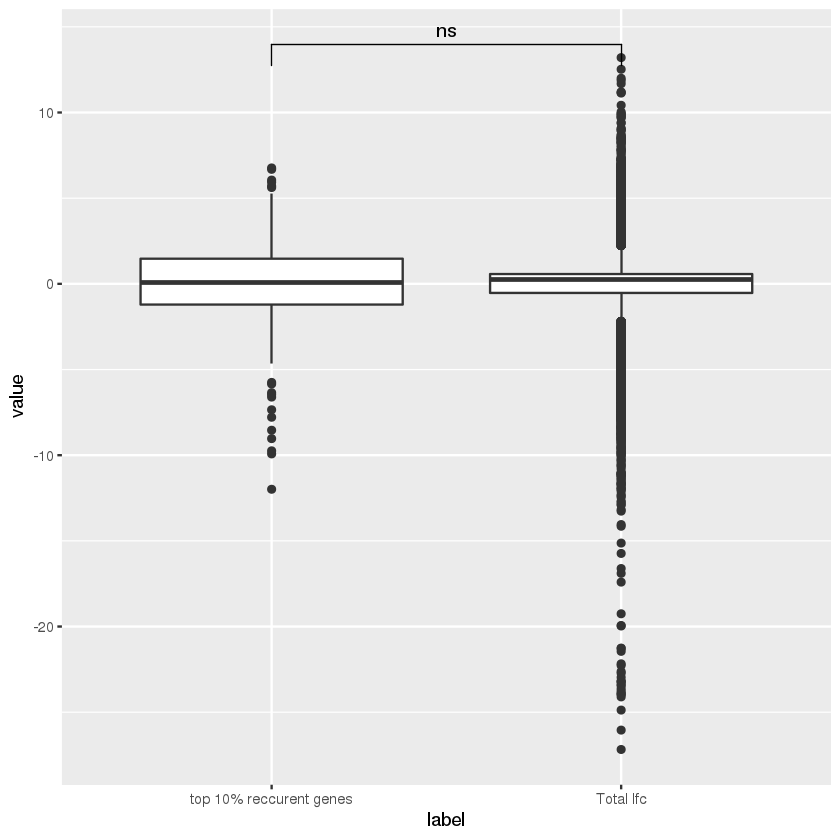

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


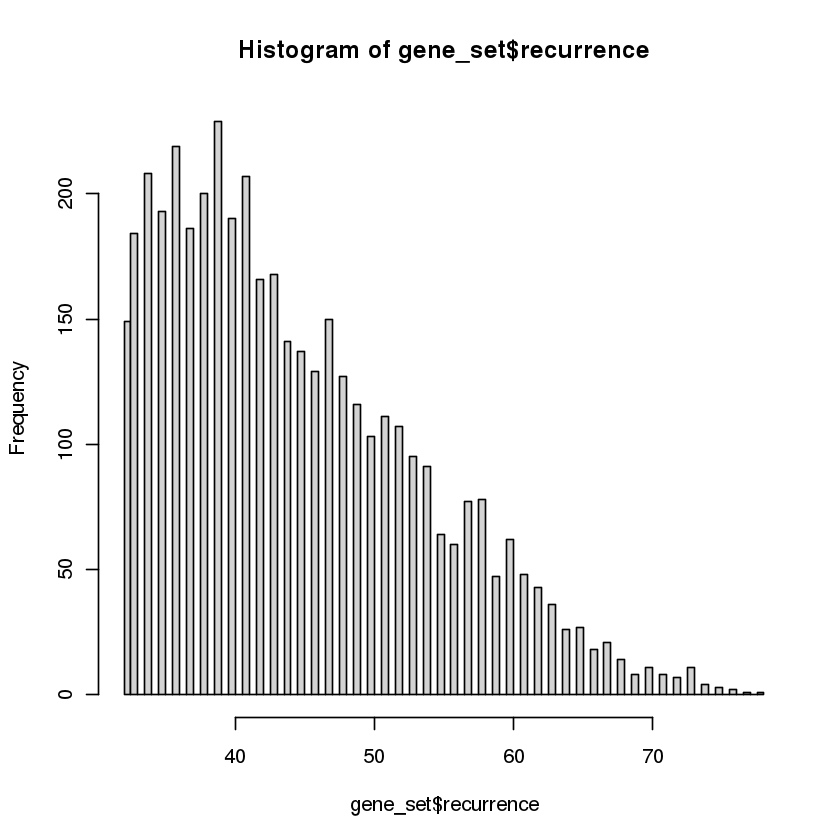

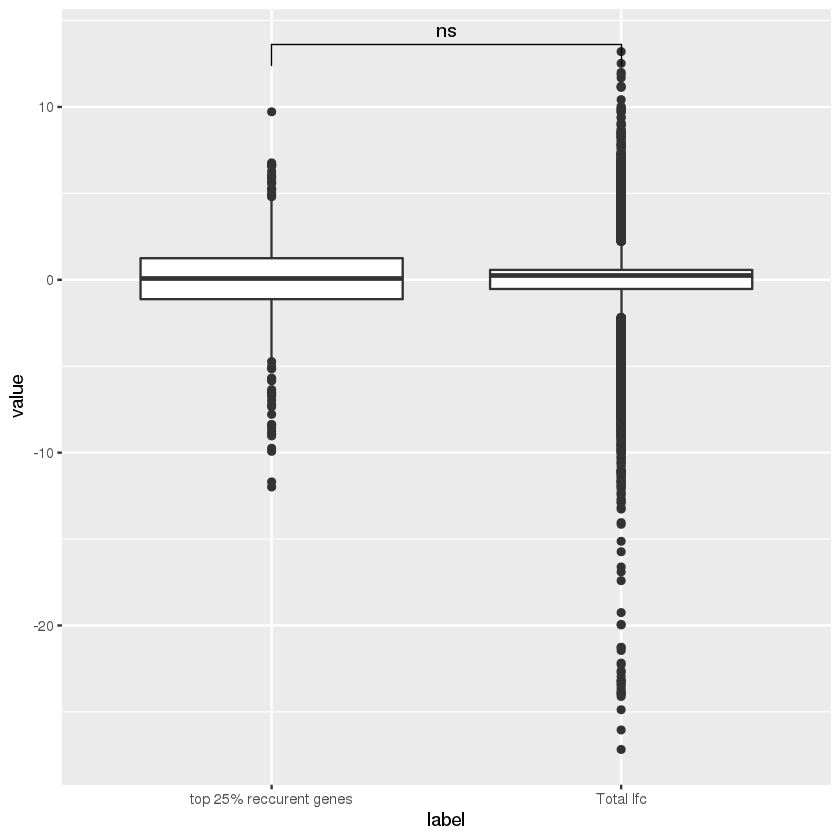

Warning message:
“Removed 1207 rows containing non-finite values (stat_boxplot).”


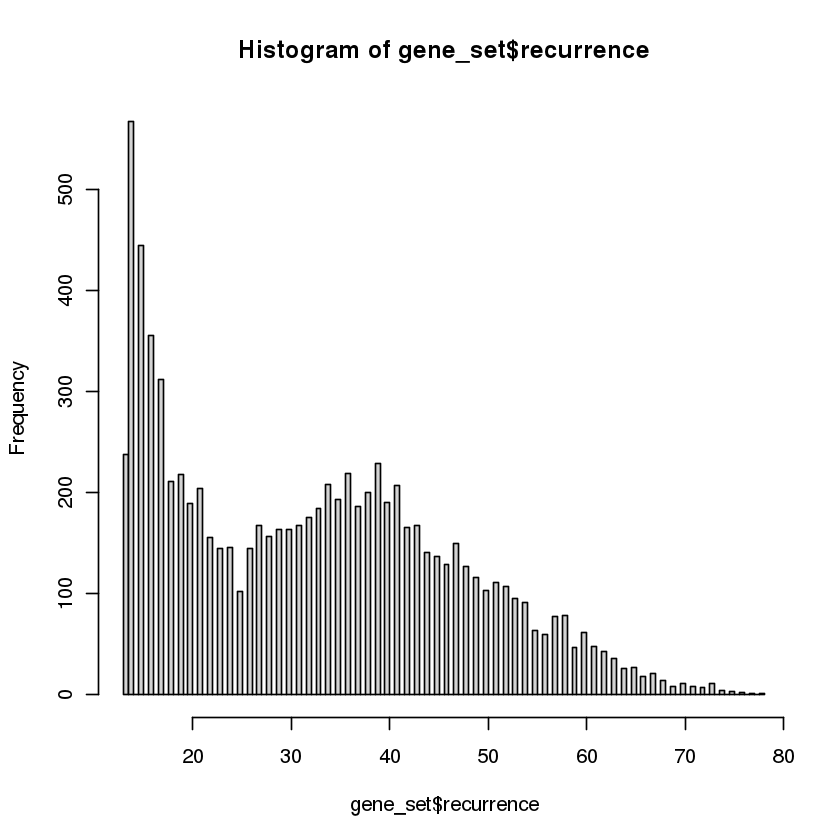

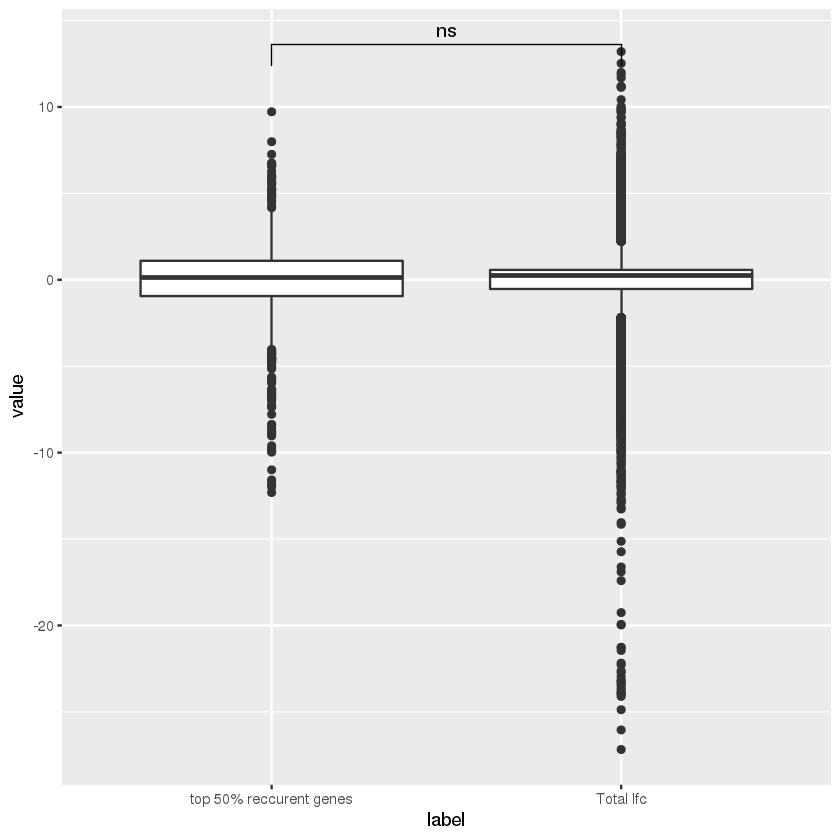

In [13]:
get_lfc_boxplot(stress_recurrent[["5"]],skin_logfc, "top 5% reccurent genes")
get_lfc_boxplot(stress_recurrent[["10"]],skin_logfc, "top 10% reccurent genes")
get_lfc_boxplot(stress_recurrent[["25"]],skin_logfc, "top 25% reccurent genes")
get_lfc_boxplot(stress_recurrent[["50"]],skin_logfc, "top 50% reccurent genes")

[1] "total genes = 164271"
[1] "unique genes = 10087"


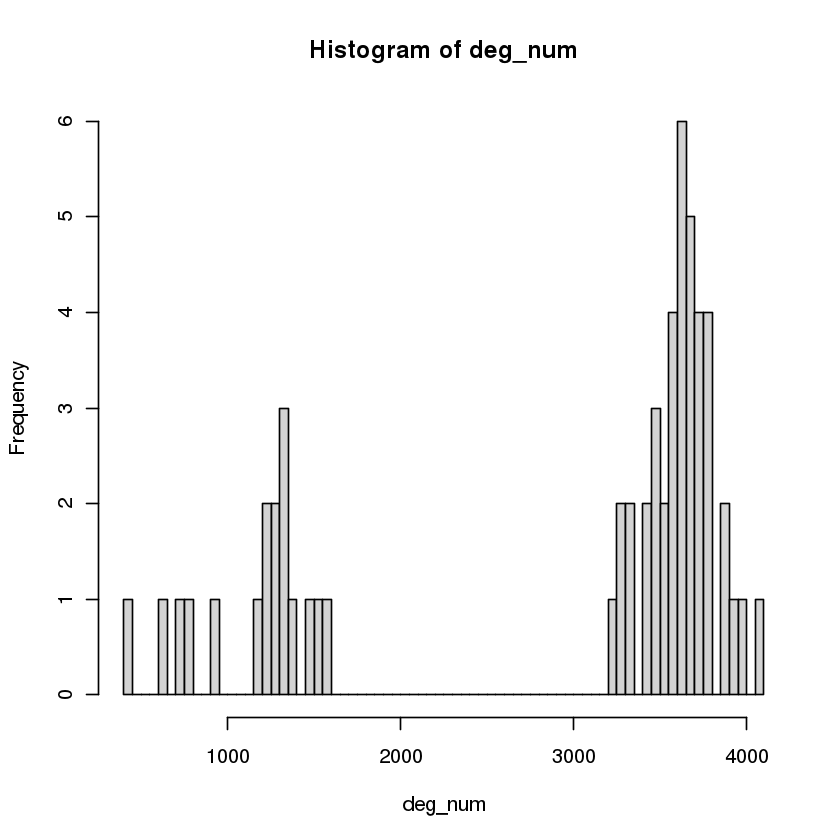

In [14]:
regen_recurrent <- get_cross_species_data('./regen_genes/', "^GSE.*up", "regen")

In [15]:
regen_recurrent[["5"]][1:10,]

,recurrence,gene
,<dbl>,<chr>
TPM1,49,TPM1
DNM1L,48,DNM1L
PRDX4,48,PRDX4
MYH11,47,MYH11
ABCA1,46,ABCA1
TUBA1A,46,TUBA1A
SURF4,46,SURF4
ANXA2,45,ANXA2
CNDP2,45,CNDP2


Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


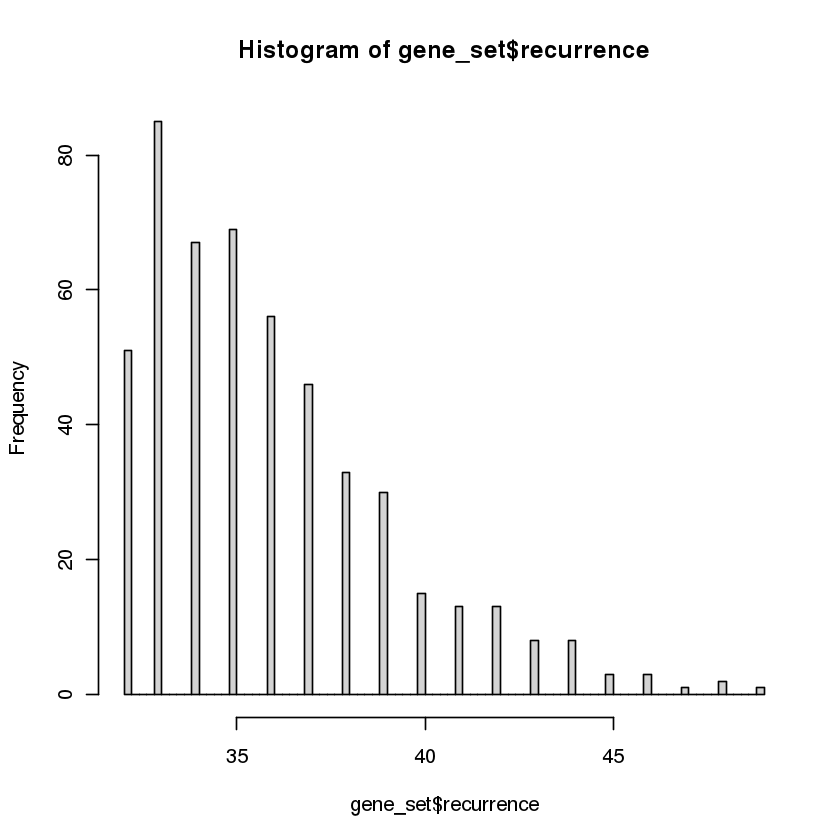

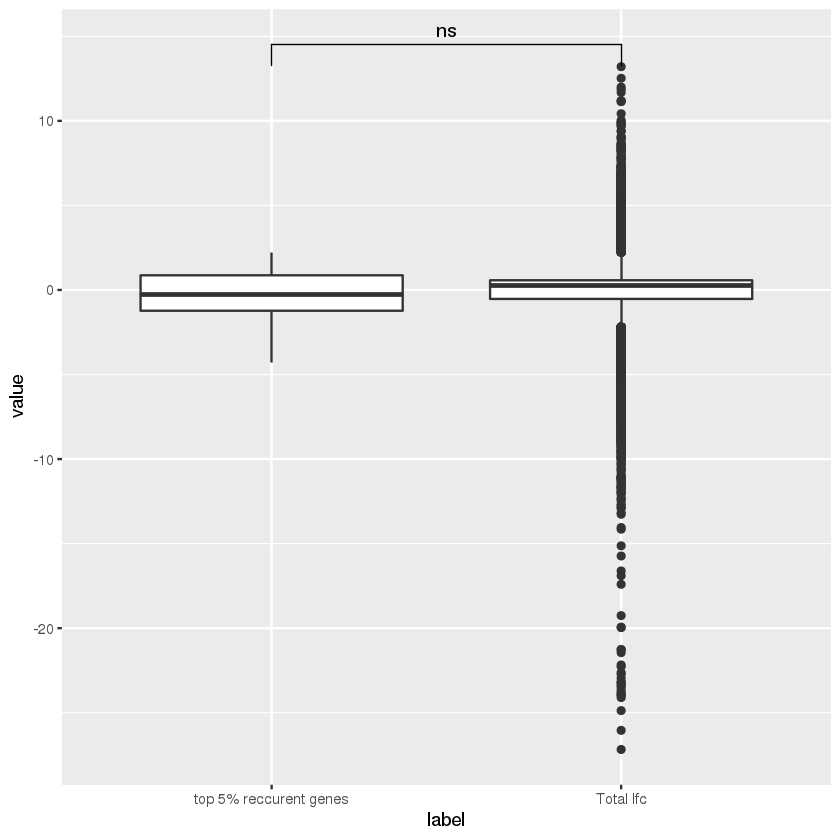

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


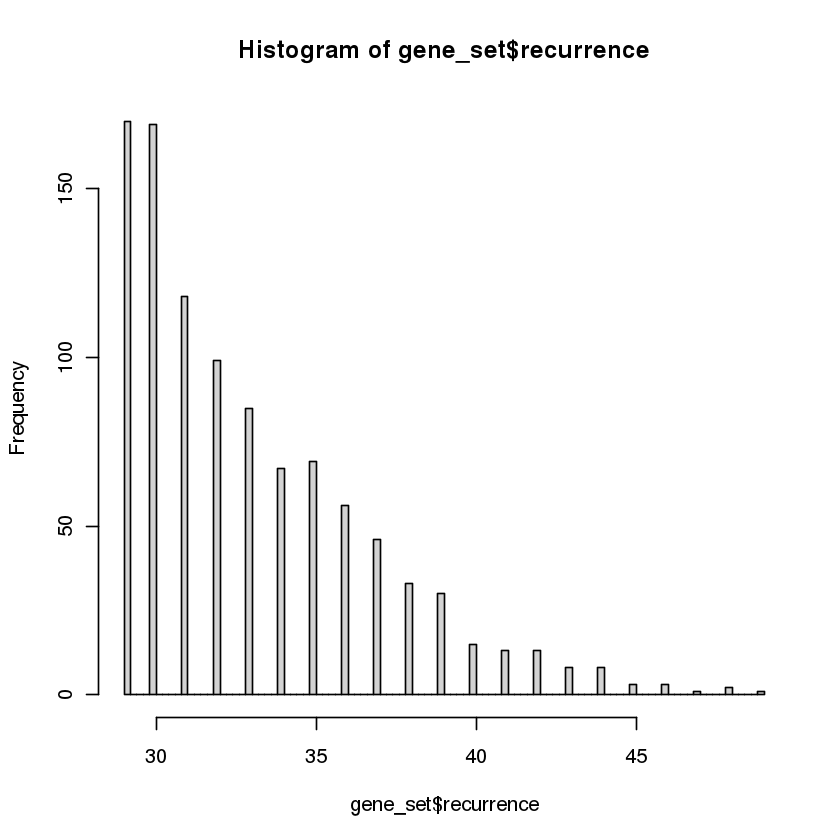

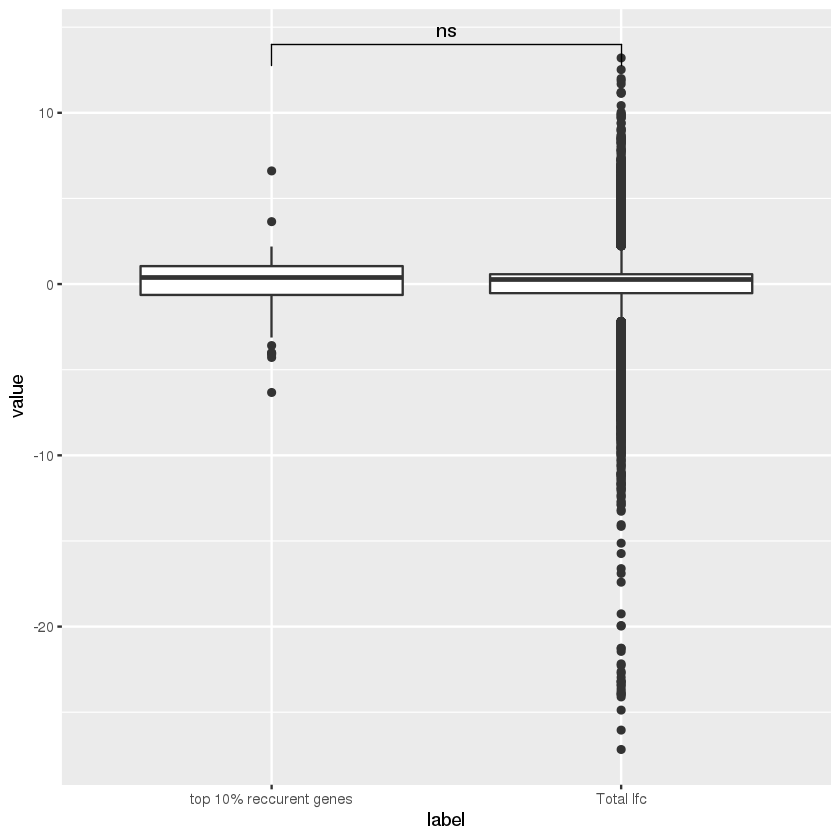

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


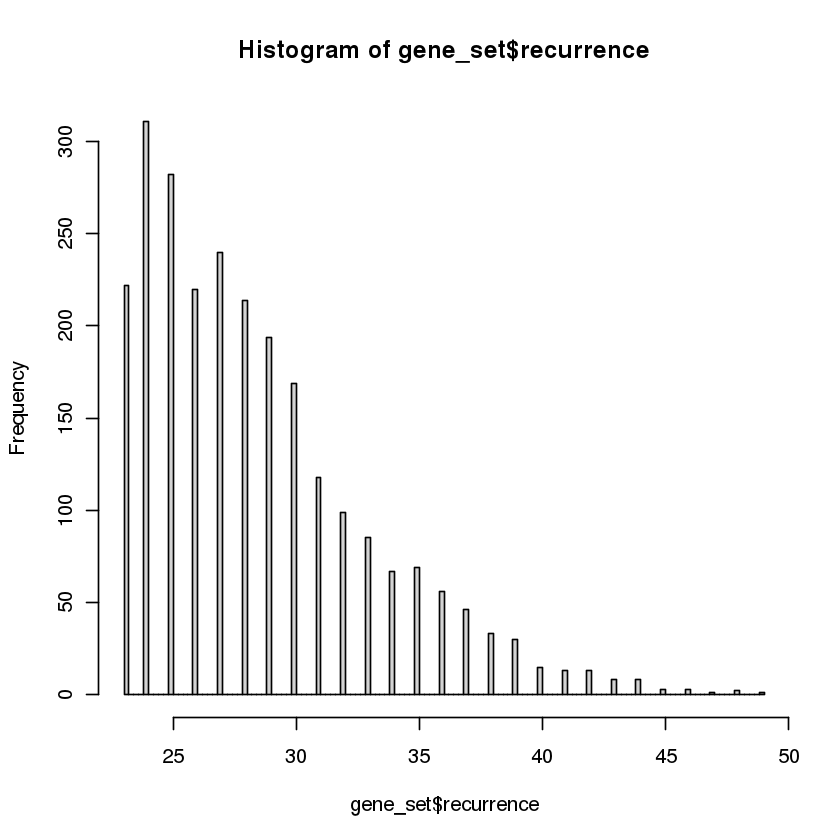

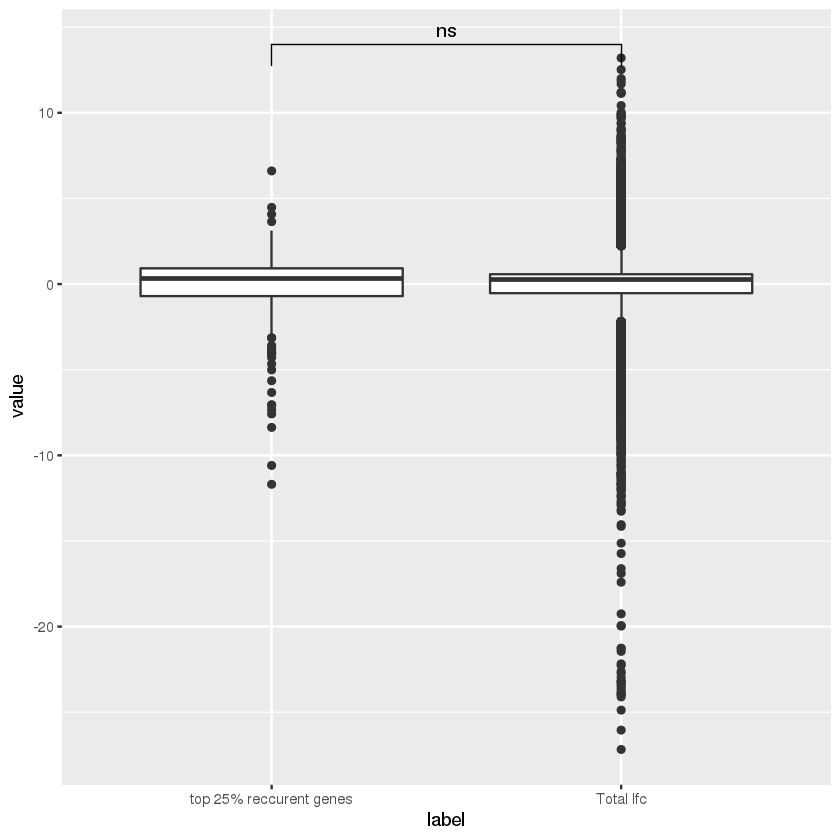

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


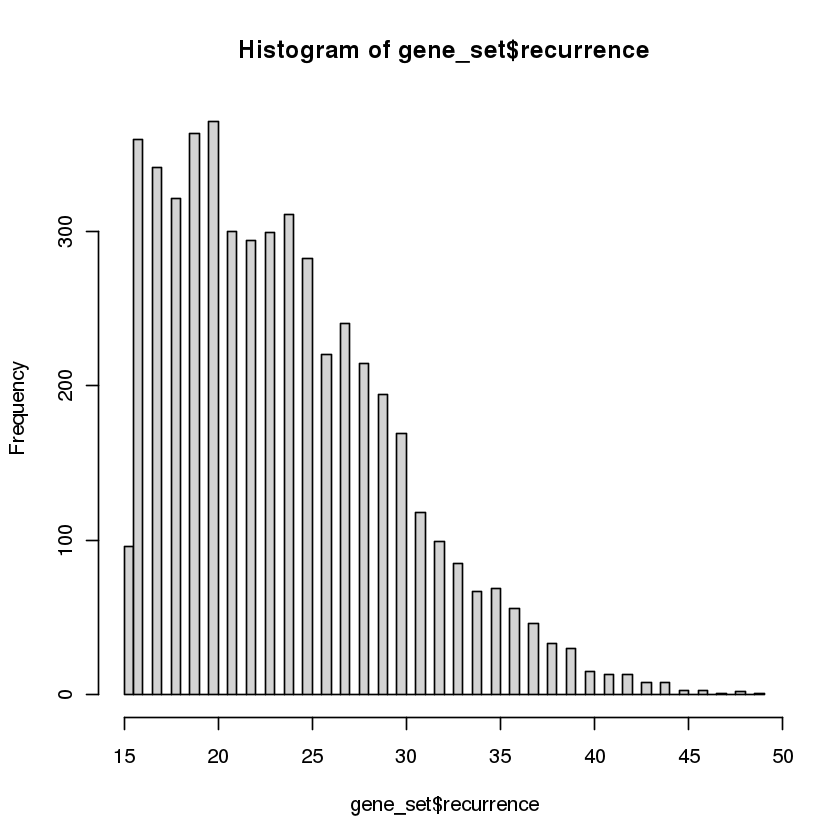

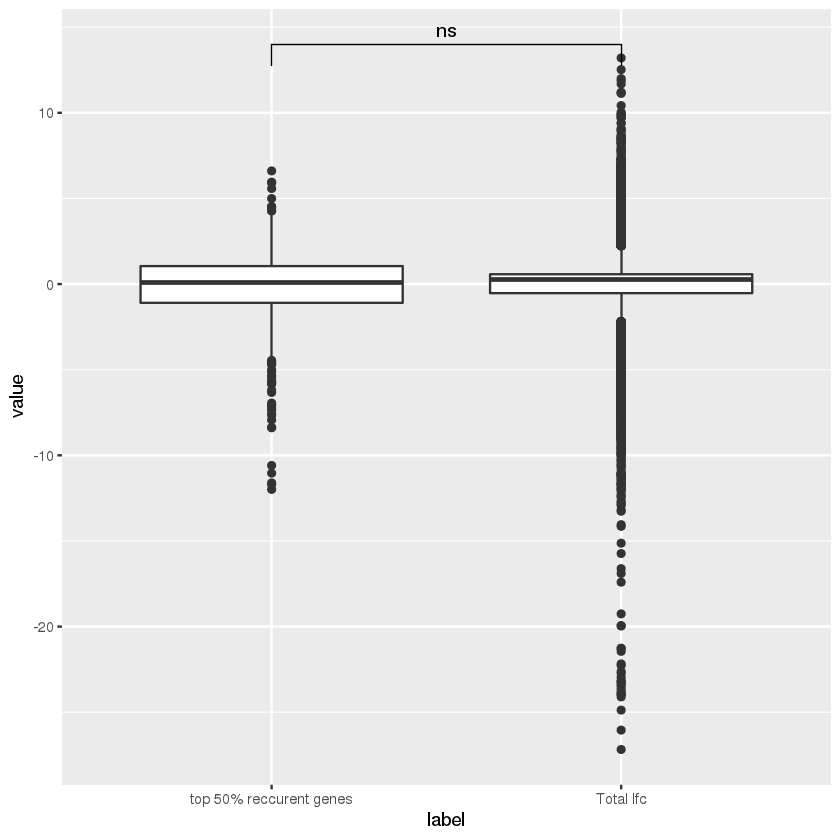

In [16]:
get_lfc_boxplot(regen_recurrent[["5"]],skin_logfc, "top 5% reccurent genes")
get_lfc_boxplot(regen_recurrent[["10"]],skin_logfc, "top 10% reccurent genes")
get_lfc_boxplot(regen_recurrent[["25"]],skin_logfc, "top 25% reccurent genes")
get_lfc_boxplot(regen_recurrent[["50"]],skin_logfc, "top 50% reccurent genes")

[1] "total genes = 238879"
[1] "unique genes = 14108"


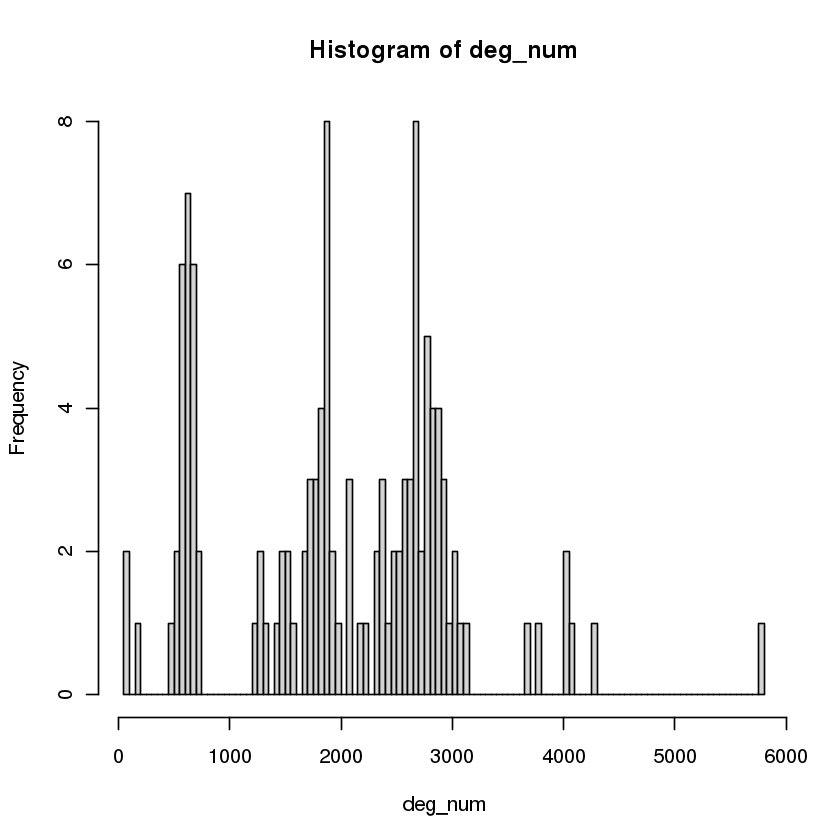

In [13]:
deg_num <- numeric(length(wound_files))
gene_list <- character(0)
total_genes <- character(0)
recurrent_genes <- list()
uniq_genes <- 
for(i in 1:length(wound_files)) {
    current_file <- fread(paste('./wound_genes/', wound_files[i], sep=""), header=F)
    
    #print(head(current_file$V1))
    gene_list <- c(unique(append(gene_list, unique(current_file$V1), length(gene_list))))
    total_genes <- c(append(total_genes, unique(current_file$V1), length(total_genes)))
    deg_num[i] <- (length(unique(current_file$V1)))

}

for(i in 1:length(total_genes)) {
    if (!(total_genes[i] %in% names(recurrent_genes))) {
        recurrent_genes[[total_genes[i]]] <- 1
    } else {
        recurrent_genes[[total_genes[i]]] <- recurrent_genes[[total_genes[i]]] + 1
    }
}

print(paste("total genes = ", length(total_genes), sep = ""))
print(paste("unique genes = ", length(gene_list), sep = ""))
# histogram of the average number of upregulated genes
hist(deg_num, breaks = 100)

In [80]:
length(recurrent_genes)
gene_recurrence <- data.frame("recurrence" = unlist(recurrent_genes), "gene" = names(recurrent_genes))
top_10_recur <- gene_recurrence[order(gene_recurrence$recurrence, decreasing = T),][1:round(nrow(gene_recurrence)*.1),]
top_25_recur <- gene_recurrence[order(gene_recurrence$recurrence, decreasing = T),][1:round(nrow(gene_recurrence)*.25),]
top_50_recur <- gene_recurrence[order(gene_recurrence$recurrence, decreasing = T),][1:round(nrow(gene_recurrence)*.50),]

[1] 14108

In [81]:
skin_logfc <- data.frame(fread("skin_logfc.txt"))

Warning message in fread("skin_logfc.txt"):
“Detected 6 column names but the data has 7 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


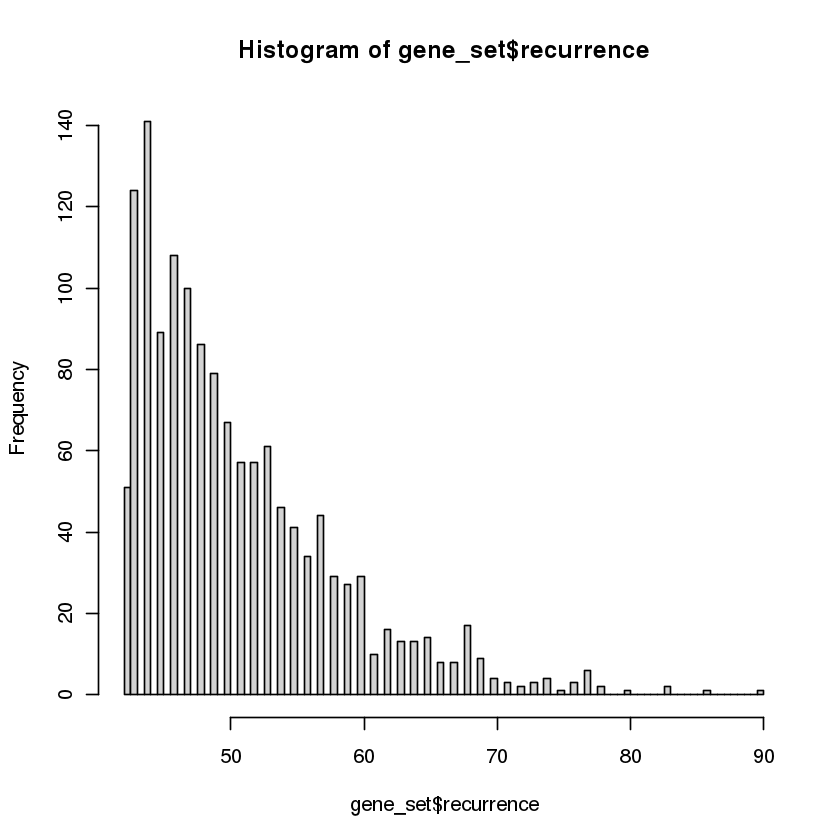

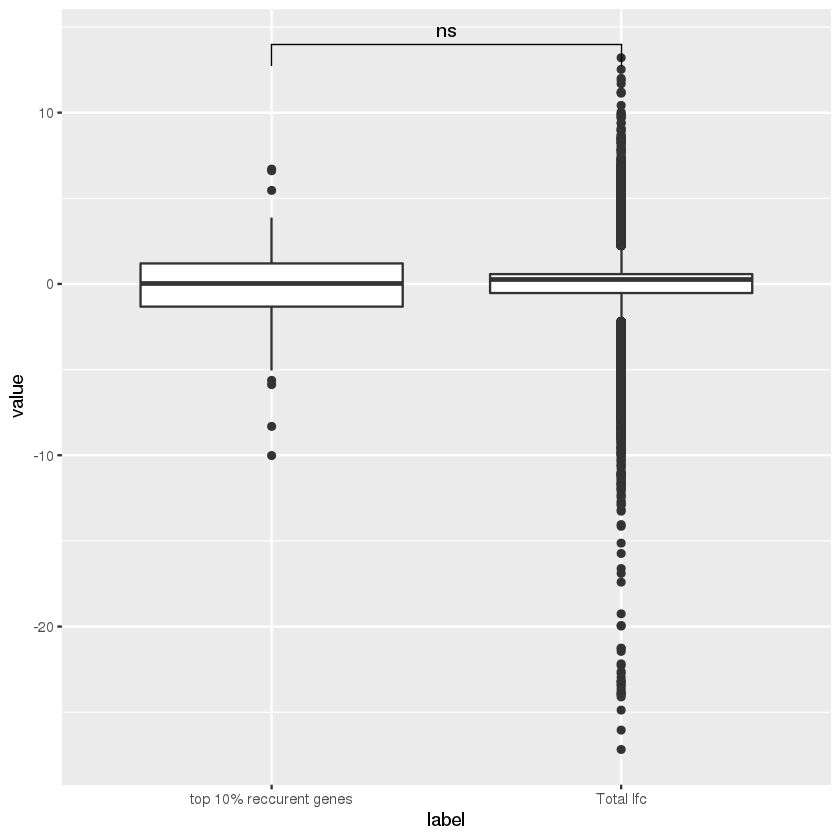

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


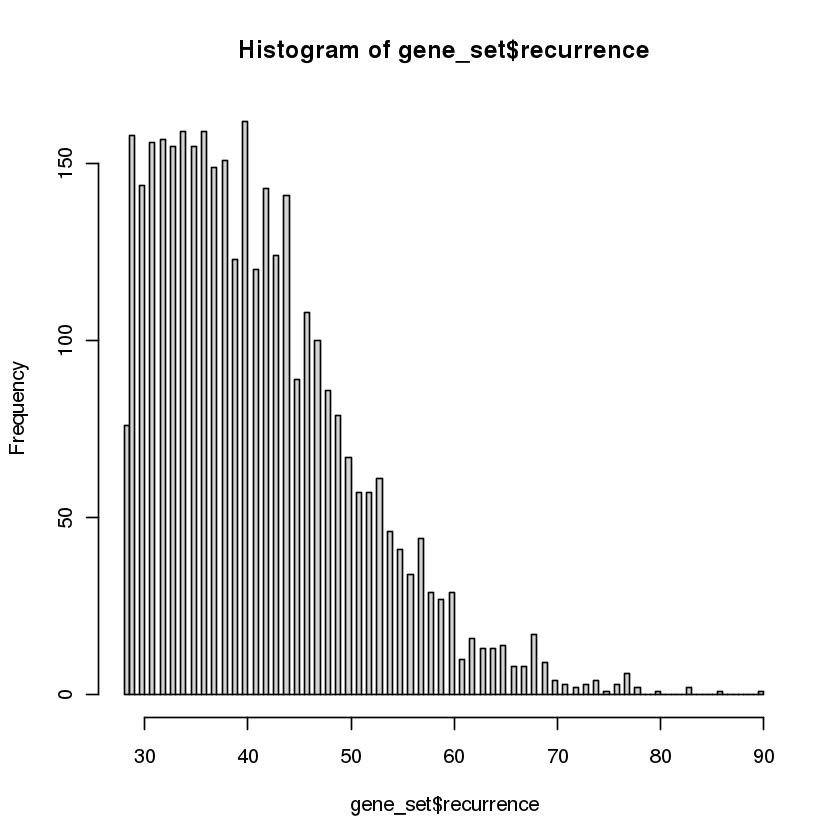

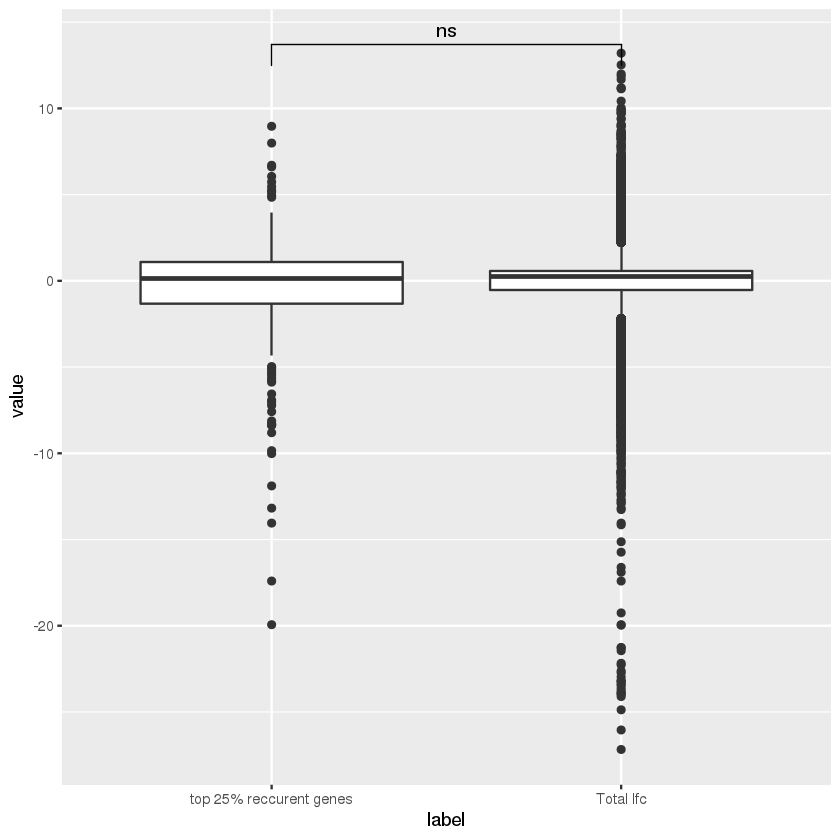

Warning message:
“Removed 1206 rows containing non-finite values (stat_boxplot).”


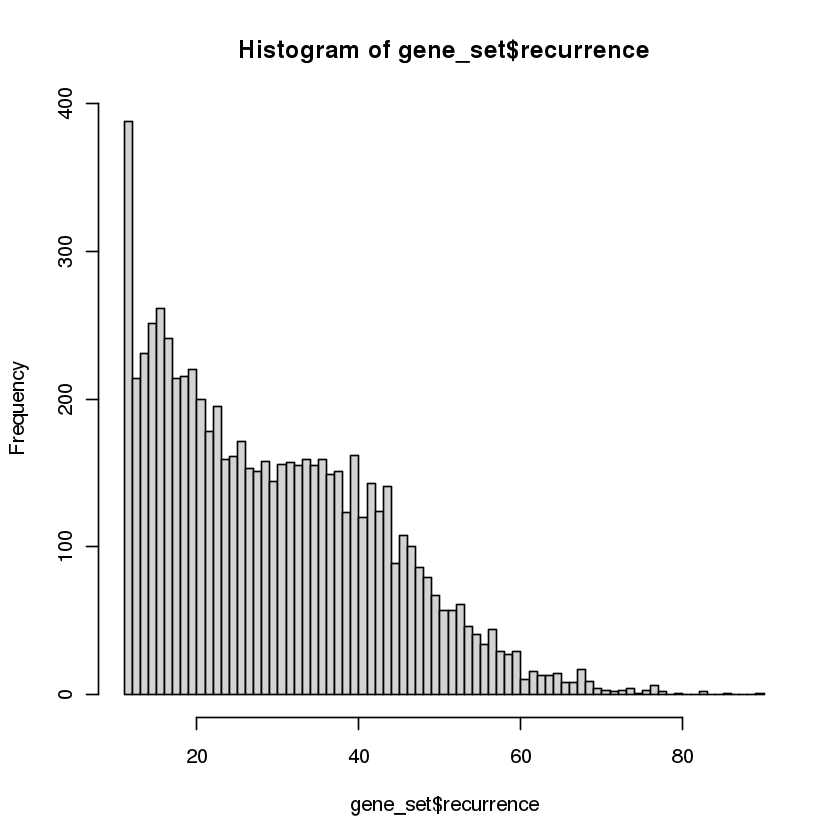

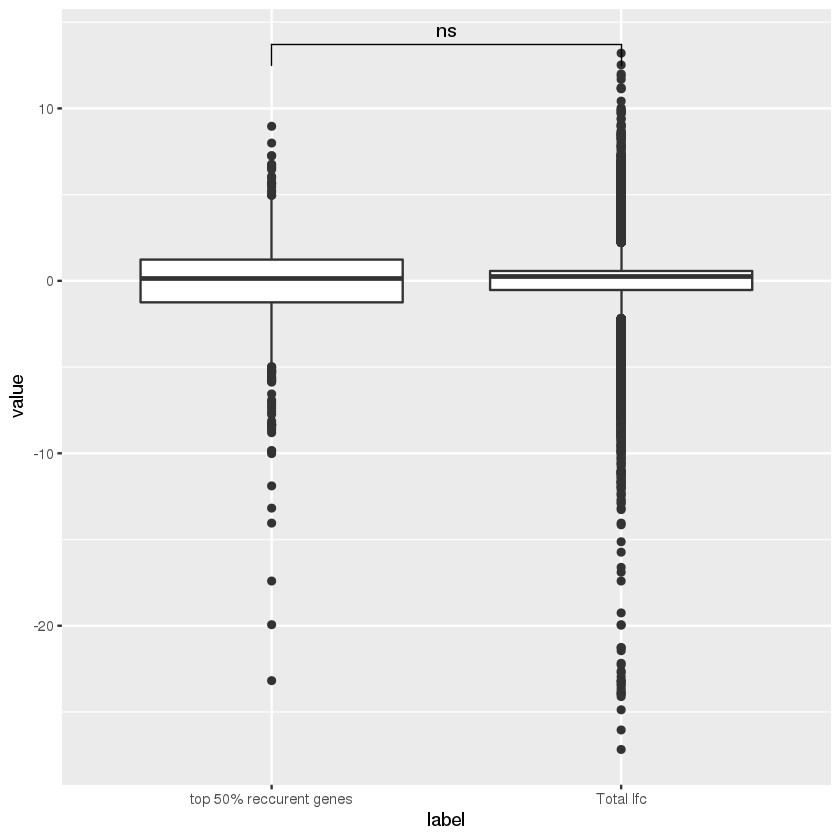

In [100]:
get_lfc_boxplot(top_10_recur,skin_logfc, "top 10% reccurent genes")
get_lfc_boxplot(top_25_recur,skin_logfc, "top 25% reccurent genes")
get_lfc_boxplot(top_50_recur,skin_logfc, "top 50% reccurent genes")

In [6]:
get_avg_degs <- function(directory, regex){
    cur_files <-list.files(directory)
    cur_files <- cur_files[grep(regex, cur_files)]

    deg_num <- numeric(length(cur_files))
    gene_list <- character(0)
    for(i in 1:length(cur_files)) {
        current_file <- fread(paste(directory, cur_files[i], sep=""), header=F)
        gene_list <- c(unique(append(gene_list, current_file$V1, length(gene_list))))
        deg_num[i] <- (nrow(current_file))
    }
    
    hist(deg_num, breaks = 100)
    return(gene_list)
}

compare_down_up <- function(directory, regex1, regex2) {
    
    uniq_up <- get_avg_degs(directory, regex1)
    uniq_down <- get_avg_degs(directory, regex2)
    
    print(length(uniq_up)-length(intersect(uniq_up, uniq_down)))
    print(length(uniq_down)-length(intersect(uniq_up, uniq_down)))
}

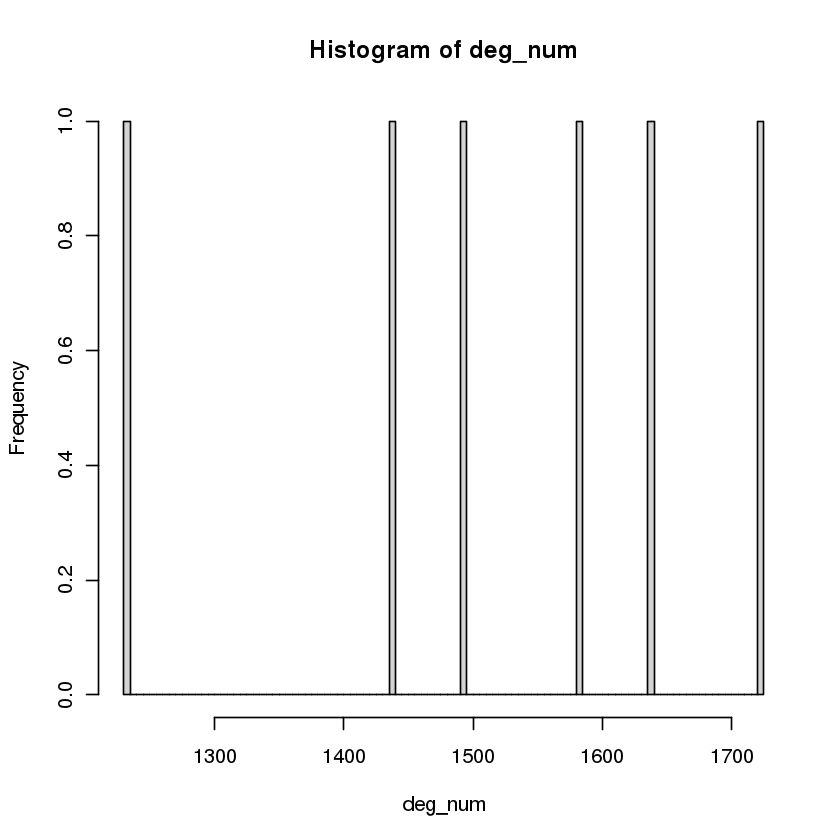

[1] 251
[1] 184


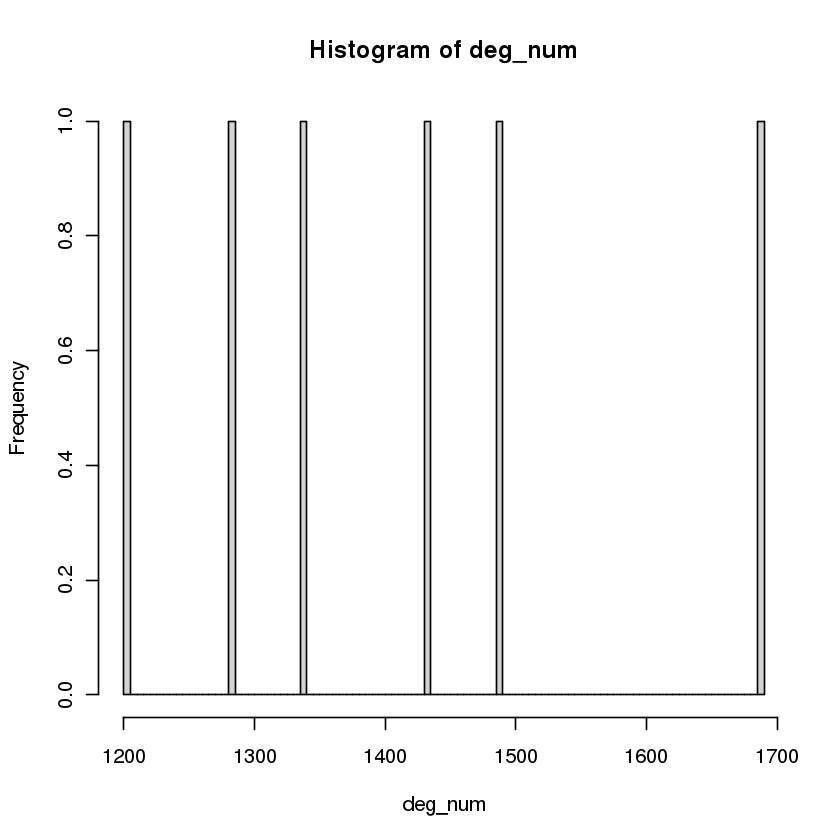

In [7]:
compare_down_up('./regen_genes/', "^GSE79299.*up", "^GSE79299.*down")

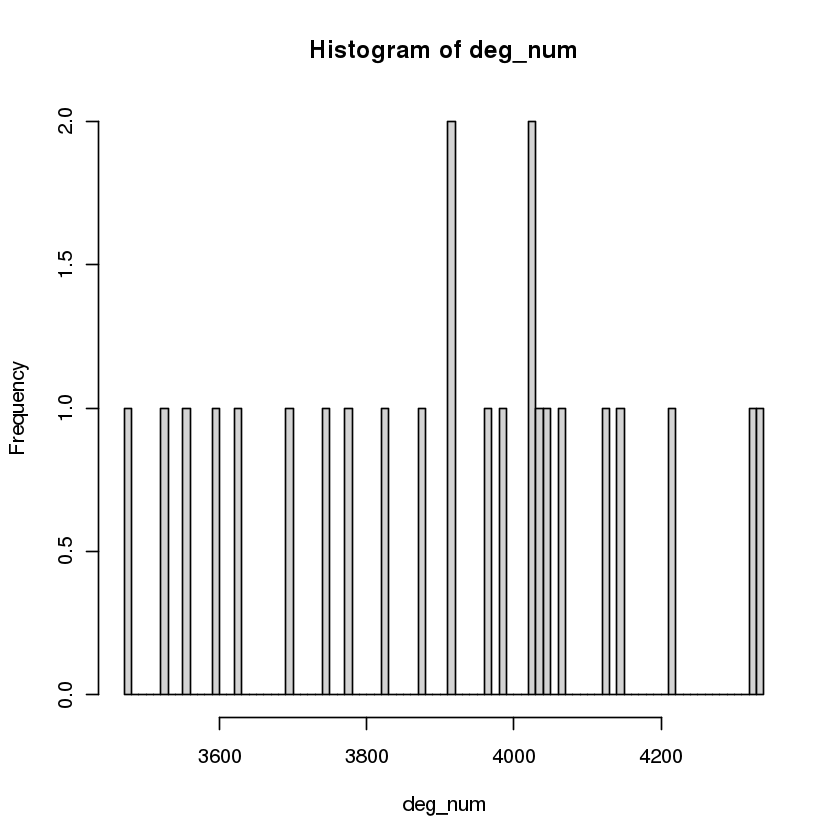

[1] 5
[1] 4


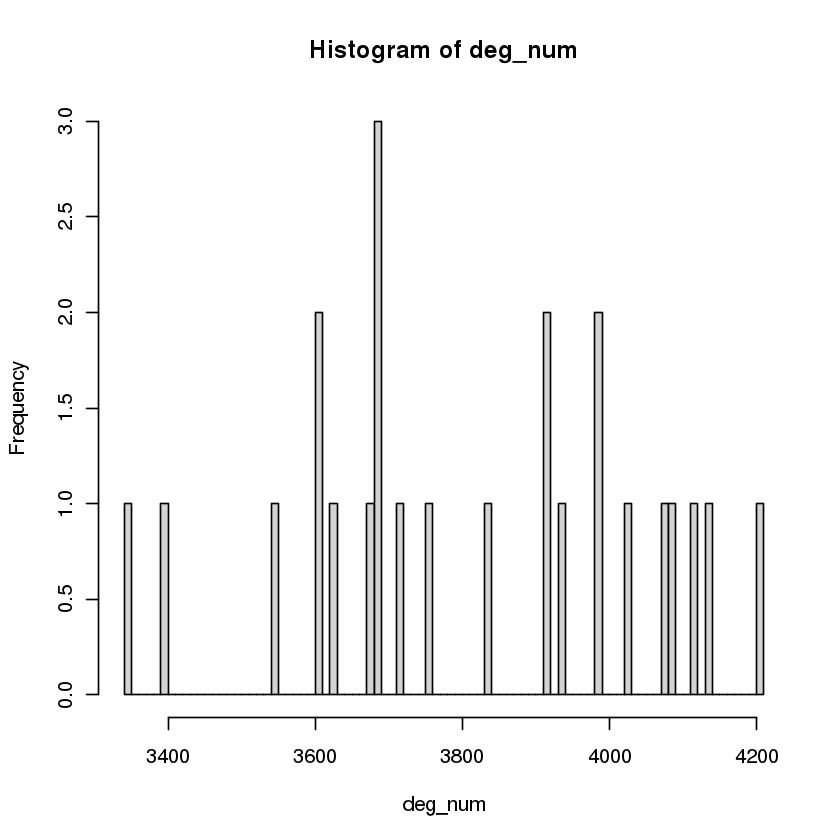

In [8]:
compare_down_up('./regen_genes/', "^GSE37198.*up", "^GSE37198.*down")

[1] "AACS"       "AADAC"      "AAK1"       "AAMDC"      "AASDHPPT"  
   [6] "AASS"       "ABAT"       "ABCA1"      "ABCA11P"    "ABCA5"     
  [11] "ABCA8"      "ABCB7"      "ABCC4"      "ABCC5"      "ABCD3"     
  [16] "ABCD4"      "ABCF2"      "ABCG1"      "ABHD10"     "ABHD17A"   
  [21] "ABHD18"     "ABHD5"      "ABHD6"      "ABI1"       "ABI2"      
  [26] "ABLIM1"     "ABR"        "ACACB"      "ACAD8"      "ACADL"     
  [31] "ACADM"      "ACADSB"     "ACAP2"      "ACAT1"      "ACBD3"     
  [36] "ACKR4"      "ACOT11"     "ACOT8"      "ACOX1"      "ACOX2"     
  [41] "ACP6"       "ACSBG1"     "ACSF2"      "ACSL1"      "ACSL3"     
  [46] "ACSM3"      "ACTR10"     "ACTR2"      "ACTR6"      "ACVR1B"    
  [51] "ACVR2A"     "ACYP1"      "ACYP2"      "ADAM22"     "ADAM23"    
  [56] "ADAMTS9"    "ADAMTSL3"   "ADARB1"     "ADCK2"      "ADCY1"     
  [61] "ADCY2"      "ADCY6"      "ADCY7"      "ADCY9"      "ADD1"      
  [66] "ADD3"       "ADGRA2"     "ADGRG1"     "ADGRL1"     "ADH1B"     
  [71] "ADH1C"      "ADH5"       "ADNP"       "ADNP2"      "AEBP1"     
  [76] "AFF1"       "AFTPH"      "AGA"        "AGAP11"     "AGAP4"     
  [81] "AGAP5"      "AGAP6"      "AGAP7P"     "AGAP9"      "AGFG2"     
  [86] "AGL"        "AGO1"       "AGO4"       "AGTR1"      "AHCYL1"    
  [91] "AHCYL2"     "AHDC1"      "AHI1"       "AHNAK"      "AHNAK2"    
  [96] "AHR"        "AIDA"       "AK4"        "AK5"        "AKAP1"     
 [101] "AKAP10"     "AKAP11"     "AKAP12"     "AKAP13"     "AKAP7"     
 [106] "AKAP8"      "AKAP8L"     "AKAP9"      "AKR1C3"     "AKR7A2"    
 [111] "AKR7A3"     "AKT3"       "AKTIP"      "ALAD"       "ALCAM"     
 [116] "ALDH1A1"    "ALDH2"      "ALDH3A1"    "ALDH3A2"    "ALDH3B2"   
 [121] "ALDH5A1"    "ALDH6A1"    "ALDH7A1"    "ALDH9A1"    "ALDOC"     
 [126] "ALG11"      "ALG13"      "ALG6"       "ALMS1"      "ALOX12"    
 [131] "ALOXE3"     "ALPK1"      "AMACR"      "AMFR"       "AMOTL2"    
 [136] "AMPD2"      "AMT"        "AMY1A"      "AMY1B"      "AMY1C"     
 [141] "AMY2A"      "AMY2B"      "AMZ2"       "ANAPC13"    "ANAPC2"    
 [146] "ANAPC5"     "ANG"        "ANGEL2"     "ANK2"       "ANK3"      
 [151] "ANKH"       "ANKHD1"     "ANKMY1"     "ANKMY2"     "ANKRA2"    
 [156] "ANKRD10"    "ANKRD11"    "ANKRD12"    "ANKRD17"    "ANKRD27"   
 [161] "ANKRD28"    "ANKRD36"    "ANKRD36B"   "ANKRD46"    "ANKRD49"   
 [166] "ANKRD6"     "ANKS1A"     "ANKZF1"     "ANO1"       "ANO10"     
 [171] "ANOS1"      "ANP32A"     "ANP32E"     "ANTXR1"     "ANXA4"     
 [176] "ANXA9"      "AP1AR"      "AP1G2"      "AP1S2"      "AP2A2"     
 [181] "AP3D1"      "AP3S1"      "AP3S2"      "AP5Z1"      "APAF1"     
 [186] "APBA2"      "APBB2"      "APBB3"      "APC"        "APLP1"     
 [191] "APLP2"      "APOBR"      "APOC1"      "APOD"       "APOE"      
 [196] "APOLD1"     "APOOL"      "APP"        "APPBP2"     "APPL1"     
 [201] "APPL2"      "AQP1"       "AQP9"       "AQR"        "AR"        
 [206] "ARAP1"      "ARAP2"      "ARF1"       "ARF4"       "ARF6"      
 [211] "ARFGAP2"    "ARFGEF1"    "ARFGEF2"    "ARFIP1"     "ARGLU1"    
 [216] "ARHGAP12"   "ARHGAP19"   "ARHGAP24"   "ARHGAP26"   "ARHGAP29"  
 [221] "ARHGAP32"   "ARHGAP33"   "ARHGAP5"    "ARHGEF10"   "ARHGEF10L" 
 [226] "ARHGEF11"   "ARHGEF12"   "ARHGEF26"   "ARHGEF28"   "ARHGEF3"   
 [231] "ARHGEF4"    "ARHGEF5"    "ARHGEF6"    "ARHGEF7"    "ARHGEF9"   
 [236] "ARID1A"     "ARID4A"     "ARID4B"     "ARIH1"      "ARL1"      
 [241] "ARL2BP"     "ARL3"       "ARL4A"      "ARL5A"      "ARL6IP1"   
 [246] "ARL6IP5"    "ARMC1"      "ARMC8"      "ARMCX1"     "ARMCX2"    
 [251] "ARMCX3"     "ARMCX5"     "ARMCX6"     "ARNT"       "ARNTL"     
 [256] "ARPC4"      "ARPC5"      "ARRB1"      "ARSA"       "ARSD"      
 [261] "ARSF"       "ASAH1"      "ASAP1"      "ASAP2"      "ASAP3"     
 [266] "ASB1"       "ASB8"       "ASF1A"      "ASGR1"      "ASGR2"     
 [271] "ASH2L"      "ASMTL"      "ASPA"       "ASPM"       "ASPN"      
 [276] "ASS1"       "ASTE1"      "ASXL1"   

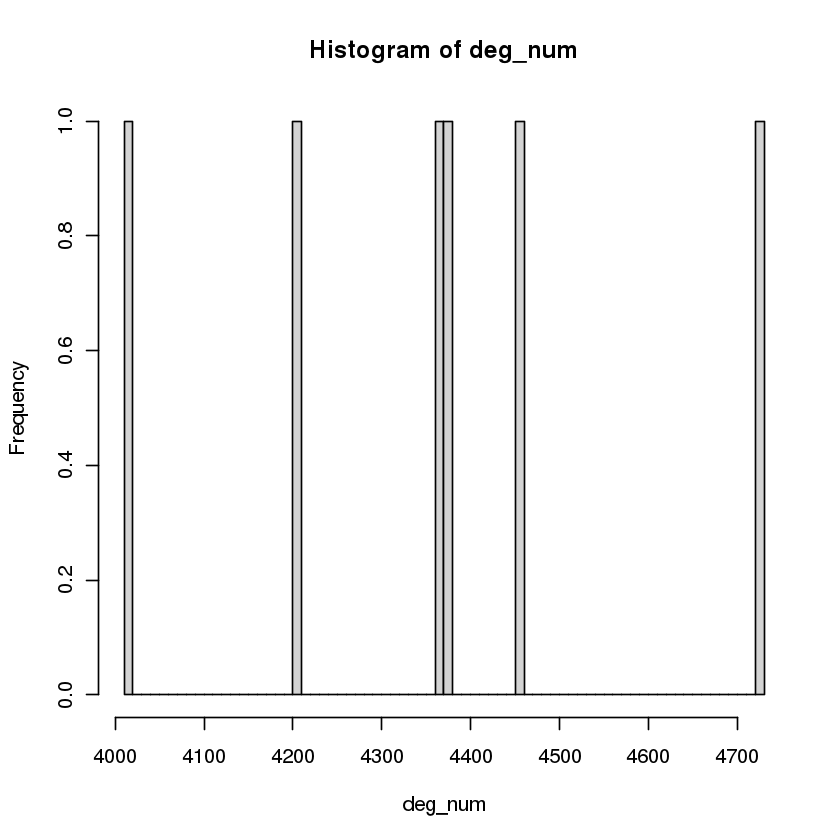

[1] "A1CF"       "AAGAB"      "AARSD1"     "AATF"       "ABCA12"    
   [6] "ABCC1"      "ABCE1"      "ABCF2"      "ABCG2"      "ABCG4"     
  [11] "ABHD11"     "ABHD17B"    "ABHD2"      "ABT1"       "ACAA1"     
  [16] "ACAA2"      "ACACA"      "ACADVL"     "ACAN"       "ACAT2"     
  [21] "ACD"        "ACLY"       "ACO2"       "ACOT11"     "ACOT7"     
  [26] "ACOT9"      "ACP1"       "ACP2"       "ACP5"       "ACR"       
  [31] "ACRV1"      "ACSL3"      "ACSL4"      "ACSL5"      "ACTB"      
  [36] "ACTBP9"     "ACTC1"      "ACTG1"      "ACTG2"      "ACTL6B"    
  [41] "ACTL7B"     "ACTN1"      "ACTR1A"     "ACTR3"      "ACY1"      
  [46] "ADAM10"     "ADAM11"     "ADAM12"     "ADAM19"     "ADAM28"    
  [51] "ADAM7"      "ADAM8"      "ADAMTS1"    "ADAMTS13"   "ADAMTS5"   
  [56] "ADAMTS7"    "ADAMTSL4"   "ADAP2"      "ADCY3"      "ADCY9"     
  [61] "ADD2"       "ADGRB1"     "ADGRE1"     "ADH5"       "ADH6"      
  [66] "ADIRF"      "ADK"        "ADM"        "ADM2"       "ADORA2B"   
  [71] "ADRA1B"     "ADRA2A"     "ADRA2B"     "ADRA2C"     "ADRM1"     
  [76] "ADSL"       "AEN"        "AFF4"       "AGAP2"      "AGFG1"     
  [81] "AGFG2"      "AGO2"       "AGPAT2"     "AGPAT4"     "AGPAT5"    
  [86] "AGPS"       "AGRN"       "AGTPBP1"    "AHCY"       "AHNAK"     
  [91] "AHSA1"      "AIF1"       "AIFM1"      "AIMP2"      "AJAP1"     
  [96] "AK1"        "AK2"        "AK6"        "AKAP8"      "AKIP1"     
 [101] "AKR1A1"     "AKR1B1"     "AKR1B10"    "AKT1"       "ALAS1"     
 [106] "ALDH1A3"    "ALDOA"      "ALDOB"      "ALG11"      "ALG13"     
 [111] "ALG3"       "ALG5"       "ALG8"       "ALOX12B"    "ALOX5AP"   
 [116] "ALOXE3"     "ALPI"       "AMBN"       "AMBRA1"     "AMD1"      
 [121] "AMDHD2"     "AMHR2"      "AMIGO2"     "AMIGO3"     "AMPD3"     
 [126] "ANAPC1"     "ANAPC15"    "ANGEL1"     "ANGPT4"     "ANGPTL2"   
 [131] "ANGPTL4"    "ANK1"       "ANKEF1"     "ANKHD1"     "ANKLE2"    
 [136] "ANP32E"     "ANPEP"      "ANXA1"      "ANXA2"      "ANXA2P1"   
 [141] "ANXA2P2"    "ANXA2P3"    "ANXA3"      "ANXA5"      "AOC2"      
 [146] "AOX1"       "AP1B1"      "AP1G1"      "AP1M2"      "AP1S1"     
 [151] "AP2B1"      "AP2S1"      "AP3B1"      "AP3B2"      "AP3D1"     
 [156] "AP3S2"      "AP5S1"      "APAF1"      "APBB2"      "APC2"      
 [161] "APCS"       "APEH"       "APEX1"      "APEX2"      "API5"      
 [166] "APLNR"      "APLP2"      "APMAP"      "APOBEC3A"   "APOBEC3B"  
 [171] "APOC2"      "APOC4"      "APOL1"      "APOL3"      "APOL6"     
 [176] "APOM"       "APOO"       "APRT"       "AQP2"       "AQP3"      
 [181] "AQP7"       "AQP8"       "ARAP3"      "ARC"        "AREG"      
 [186] "ARF3"       "ARF5"       "ARF6"       "ARFGEF2"    "ARFIP2"    
 [191] "ARFRP1"     "ARG1"       "ARG2"       "ARHGAP25"   "ARHGAP45"  
 [196] "ARHGAP8"    "ARHGDIA"    "ARHGDIB"    "ARHGEF1"    "ARHGEF18"  
 [201] "ARHGEF2"    "ARHGEF4"    "ARID3A"     "ARID5A"     "ARIH1"     
 [206] "ARIH2"      "ARL1"       "ARL4C"      "ARL4D"      "ARMC6"     
 [211] "ARNT"       "ARNTL2"     "ARPC1A"     "ARPC1B"     "ARPC3"     
 [216] "ARPC4"      "ARPC5L"     "ARPP19"     "ARRB2"      "ARSD"      
 [221] "ART1"       "ARTN"       "ASB6"       "ASCC1"      "ASCC2"     
 [226] "ASCC3"      "ASCL1"      "ASF1B"      "ASIC2"      "ASL"       
 [231] "ASTN2"      "ASXL1"      "ATAD3A"     "ATAD3B"     "ATF4"      
 [236] "ATG101"     "ATG13"      "ATG5"       "ATG7"       "ATIC"      
 [241] "ATN1"       "ATOH1"      "ATOX1"      "ATP10B"     "ATP12A"    
 [246] "ATP13A1"    "ATP13A2"    "ATP13A3"    "ATP1A1"     "ATP2A1"    
 [251] "ATP2A2"     "ATP2A3"     "ATP2B1"     "ATP2B3"     "ATP4B"     
 [256] "ATP6V0B"    "ATP6V0C"    "ATP6V0D1"   "ATP6V1C1"   "ATP6V1D"   
 [261] "ATP8B2"     "ATRNL1"     "ATXN10"     "ATXN7L1"    "AUNIP"     
 [266] "AUP1"       "AURKAIP1"   "AVEN"       "AVL9"       "AVPI1"     
 [271] "AVPR1B"     "B3GALT1"    "B3GAT1"     "B3GNT2"     "B3GNT4"    
 [276] "B4GALT1"    "B4GALT2"    "B4GALT5" 

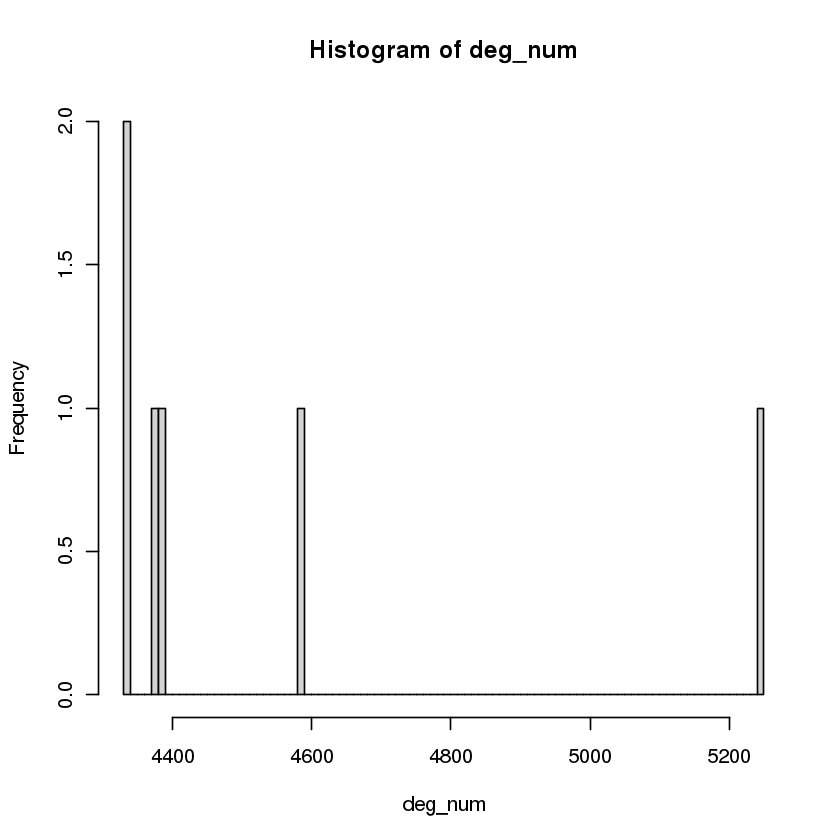

In [9]:
get_avg_degs('./wound_genes/', "^GSE147890.*up")
get_avg_degs('./wound_genes/', "^GSE147890.*down")

In [12]:
skin_logfc <- data.frame(fread("skin_logfc.txt"))
total_lfc <- skin_logfc$log2FoldChange

Warning message in fread("skin_logfc.txt"):
“Detected 6 column names but the data has 7 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


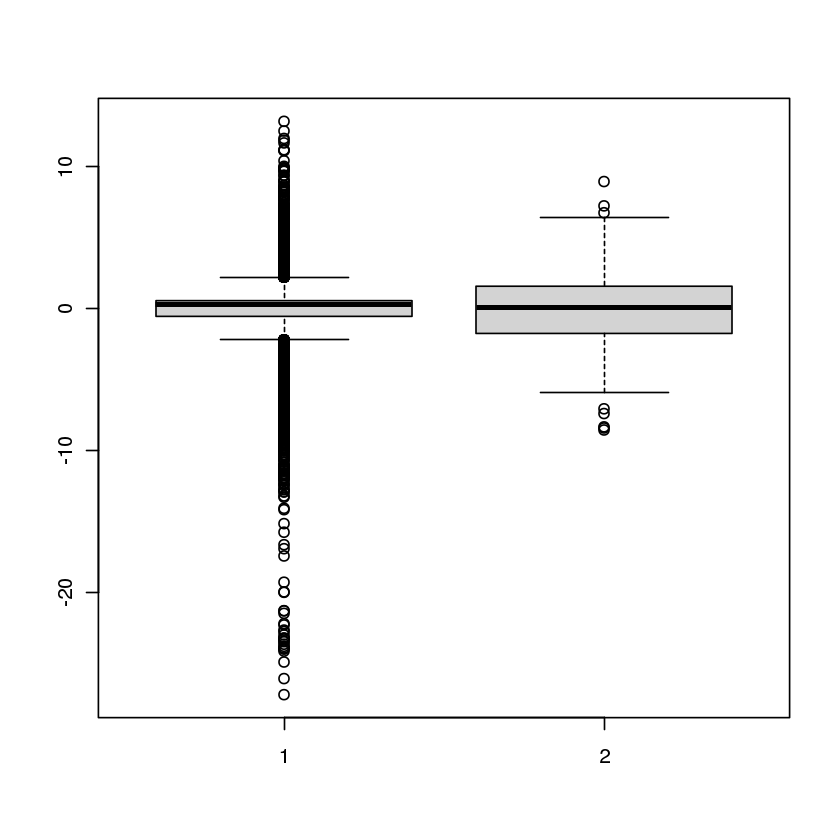

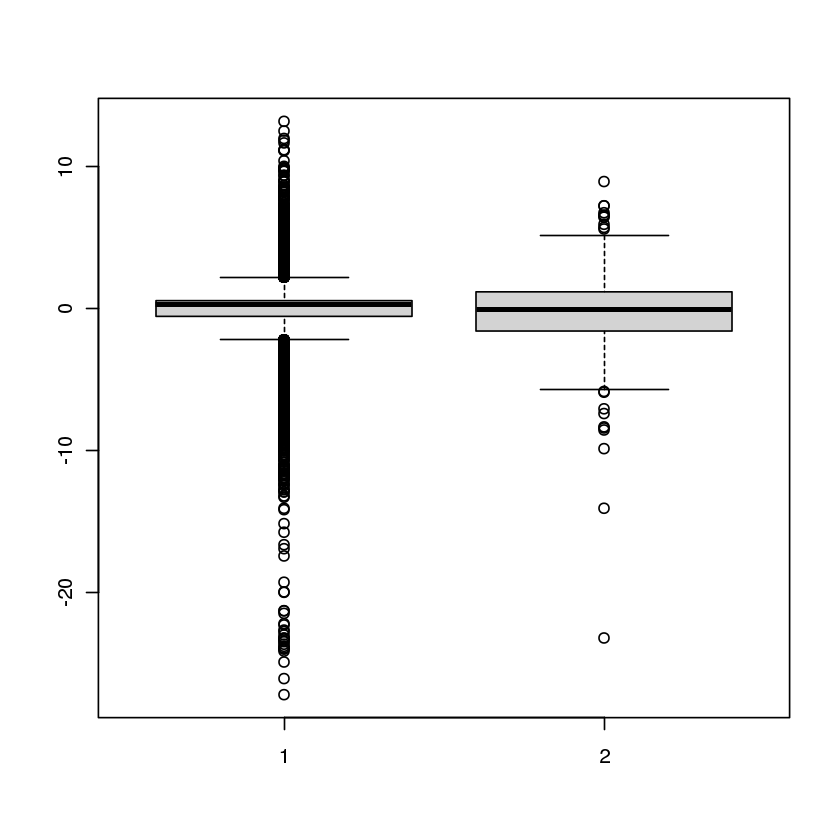

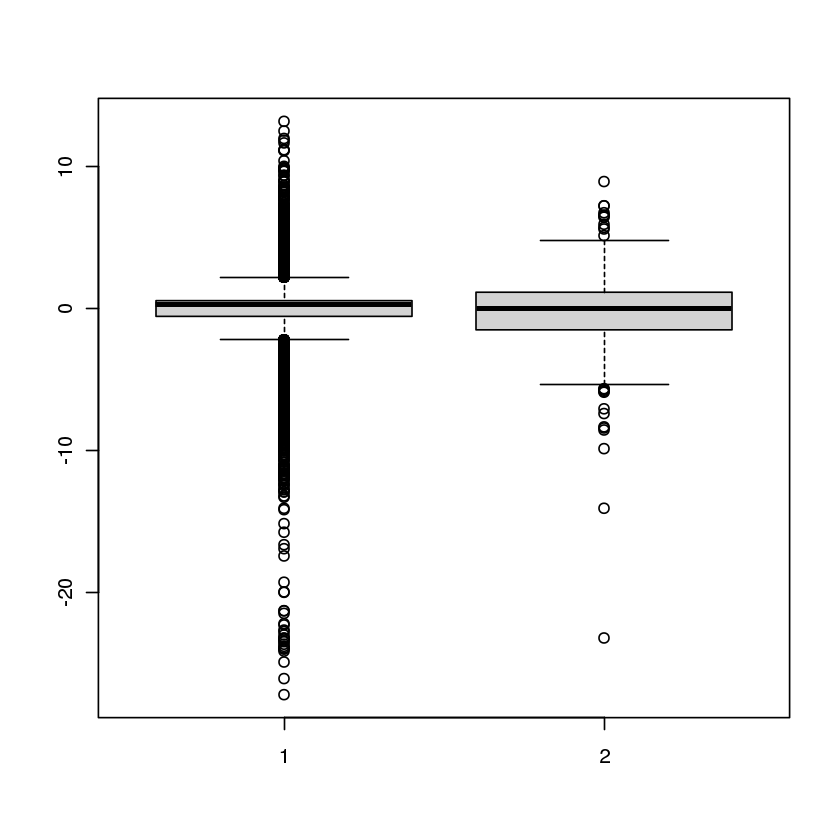

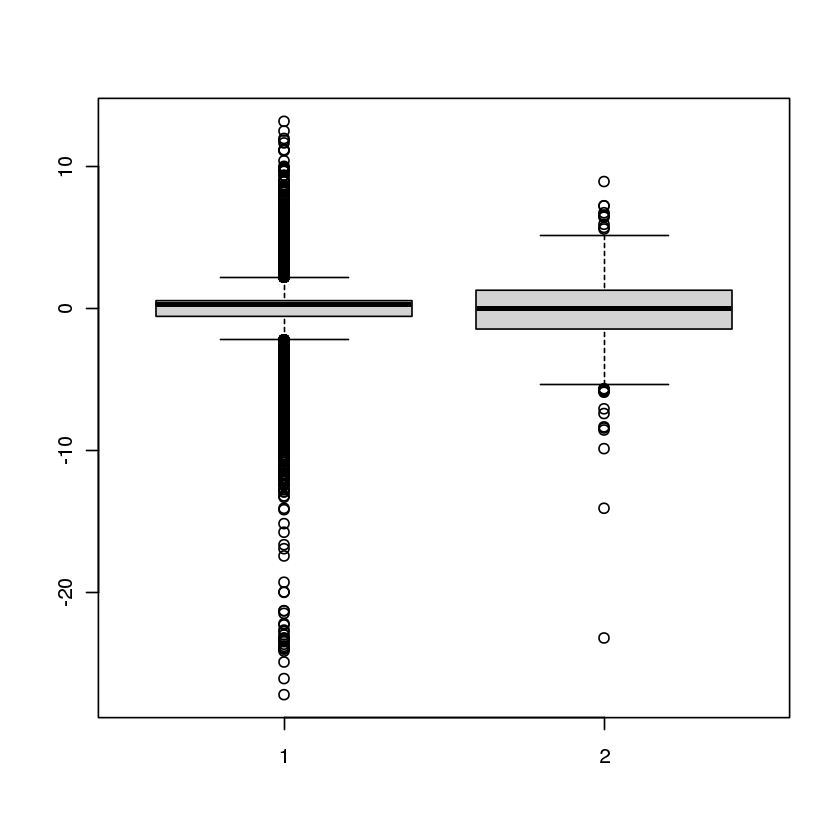

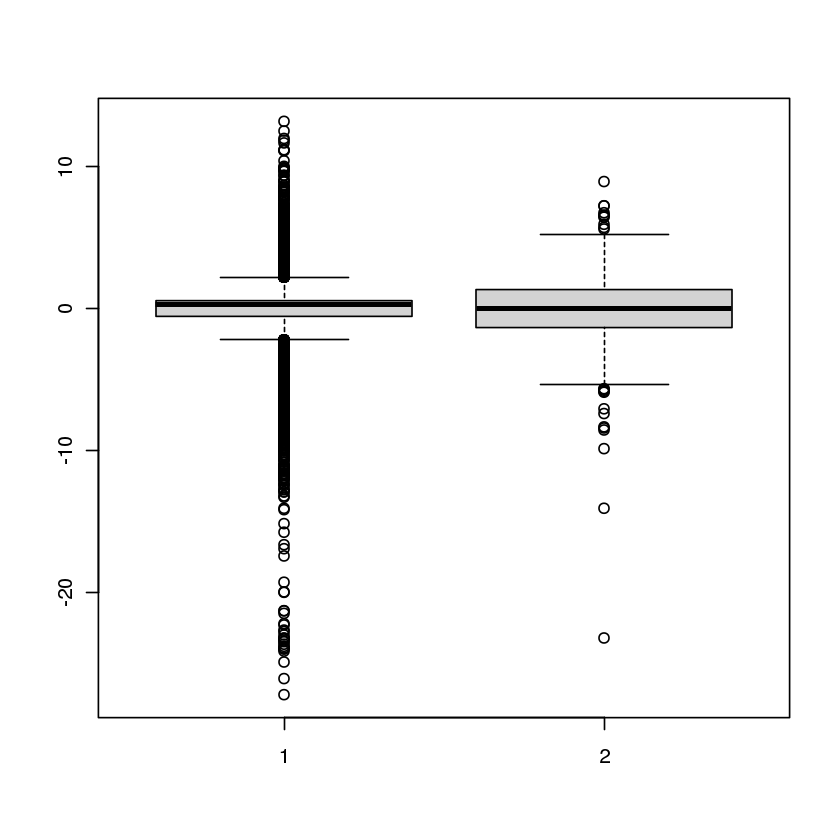

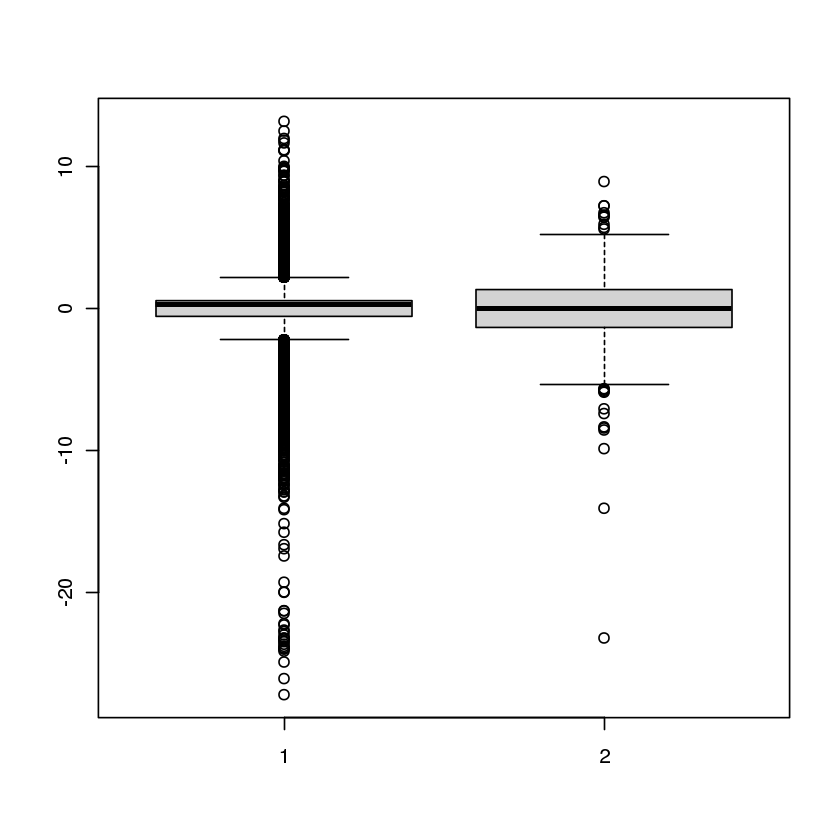

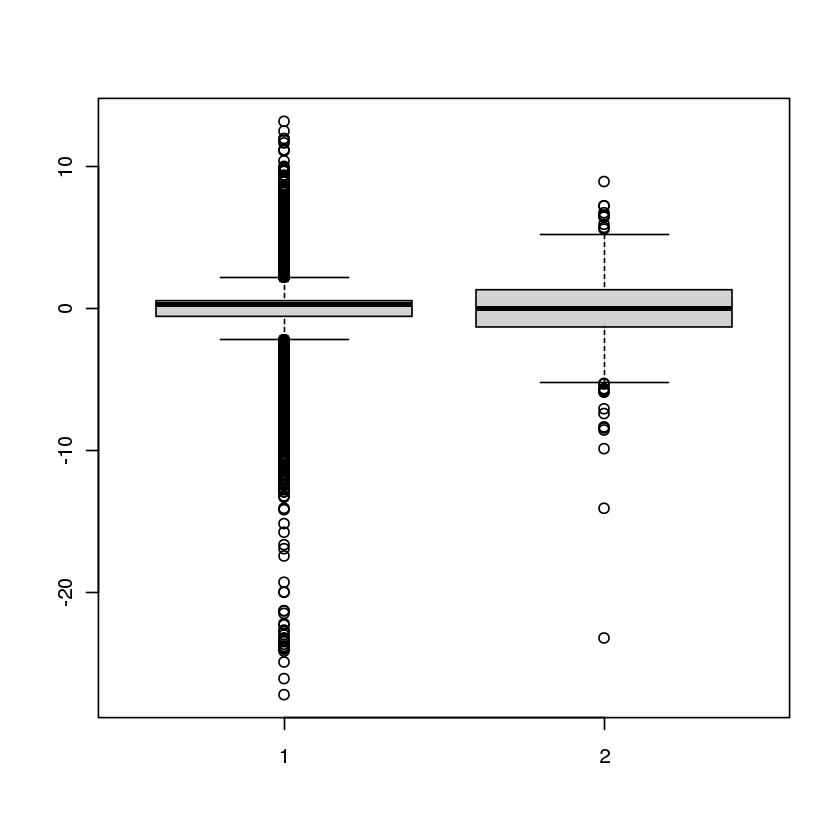

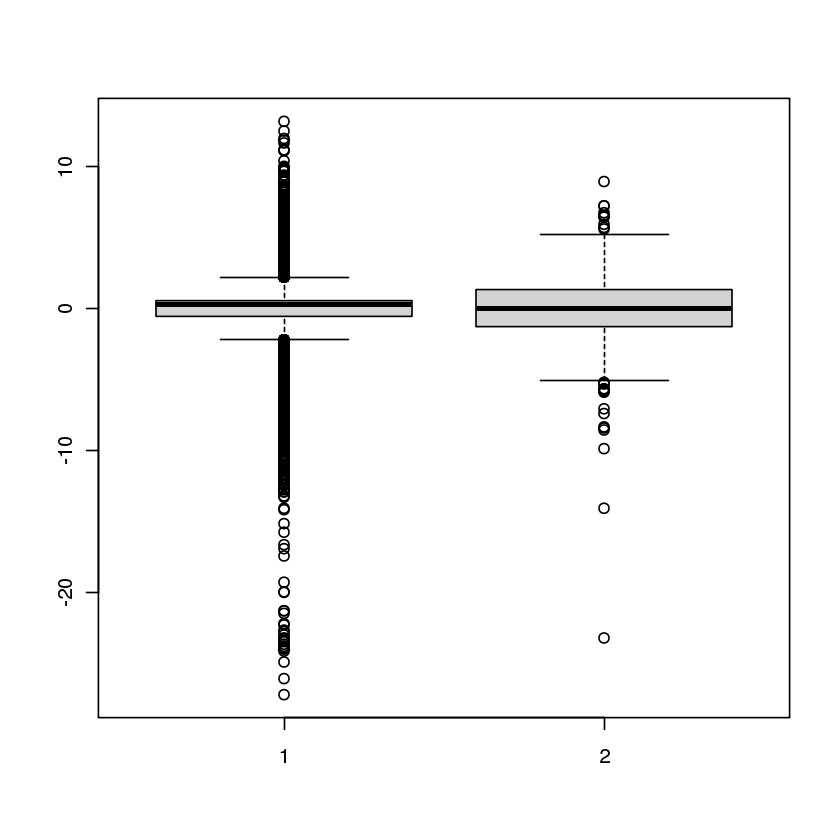

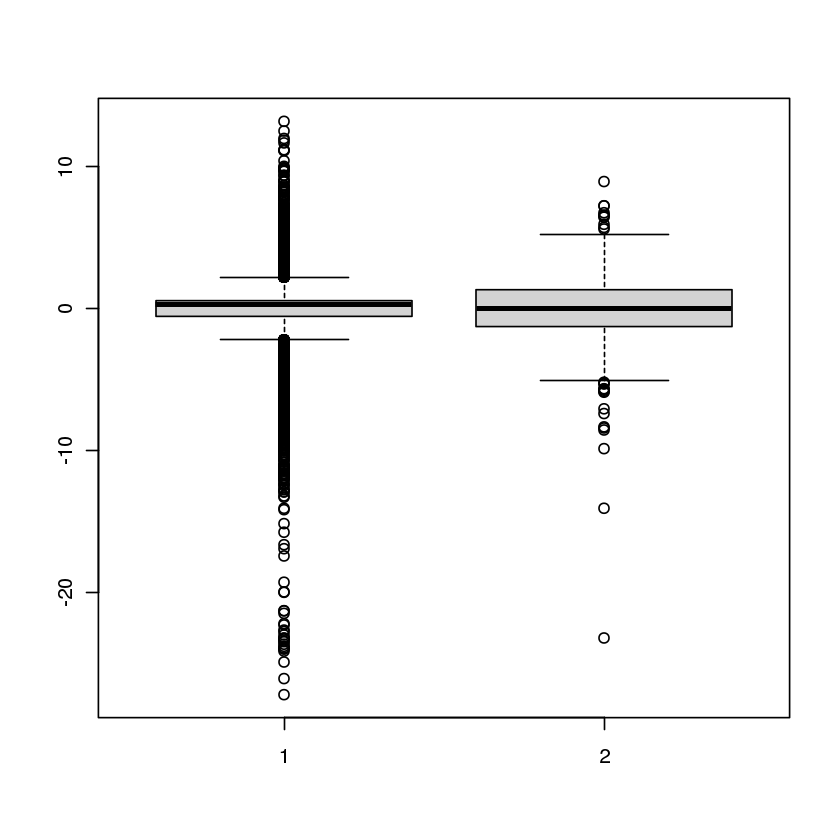

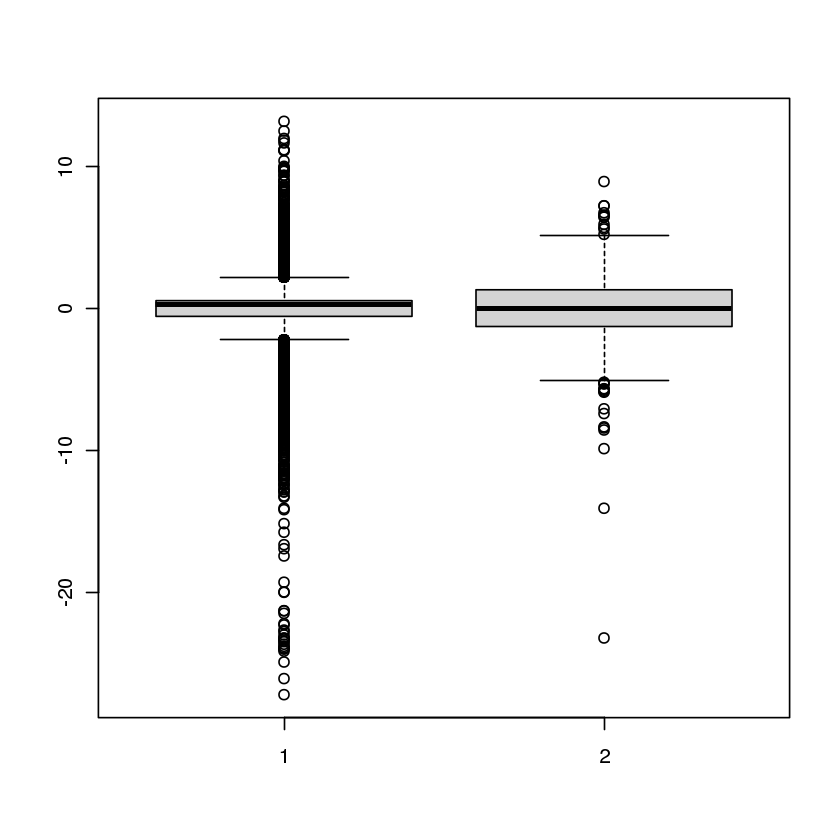

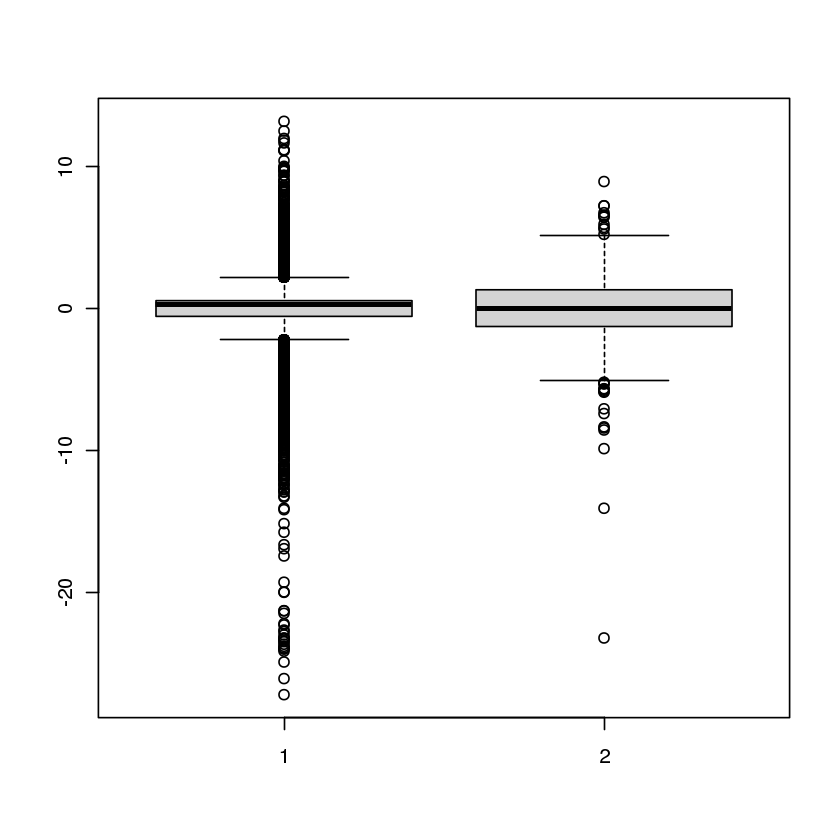

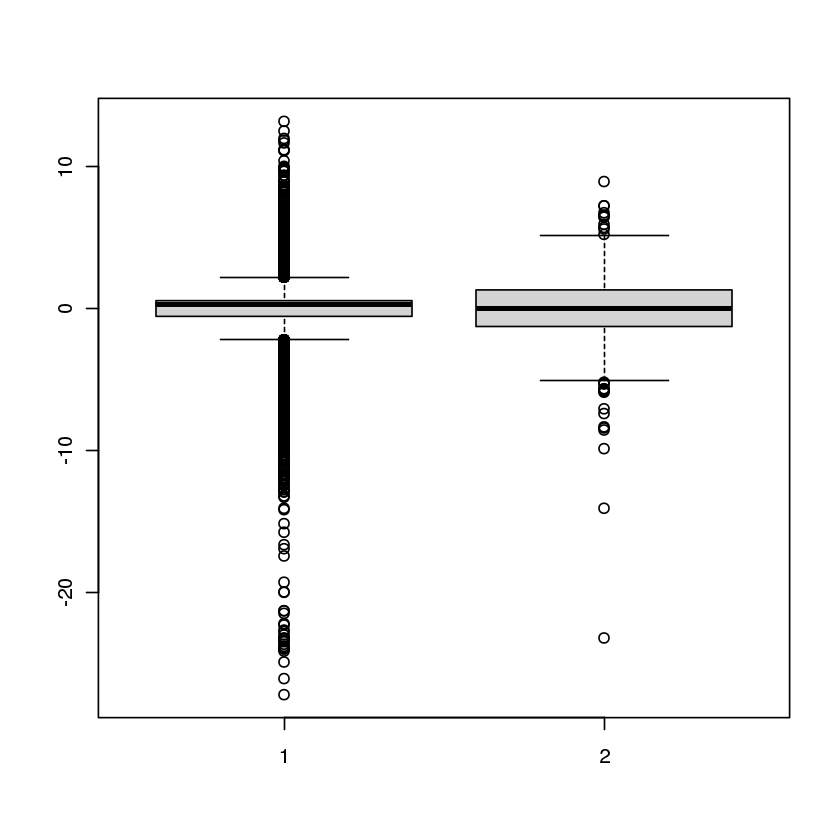

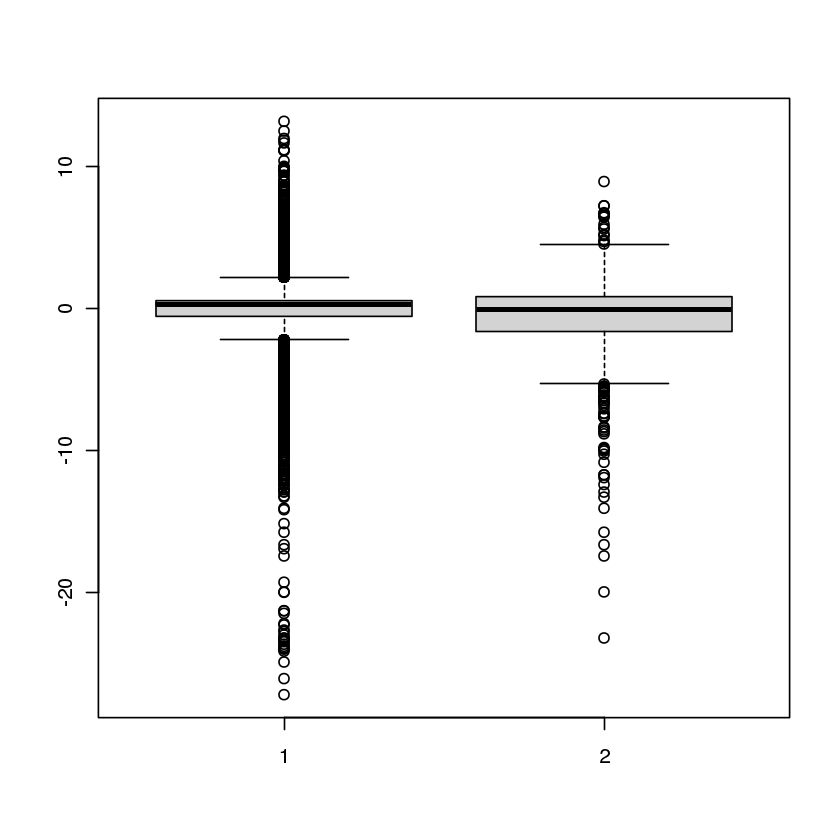

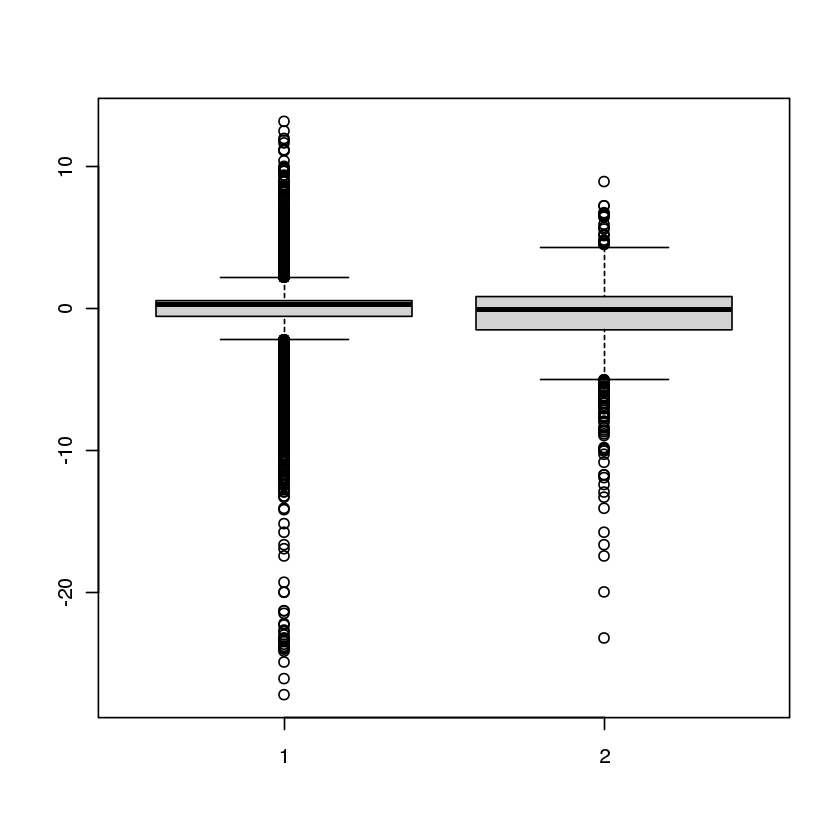

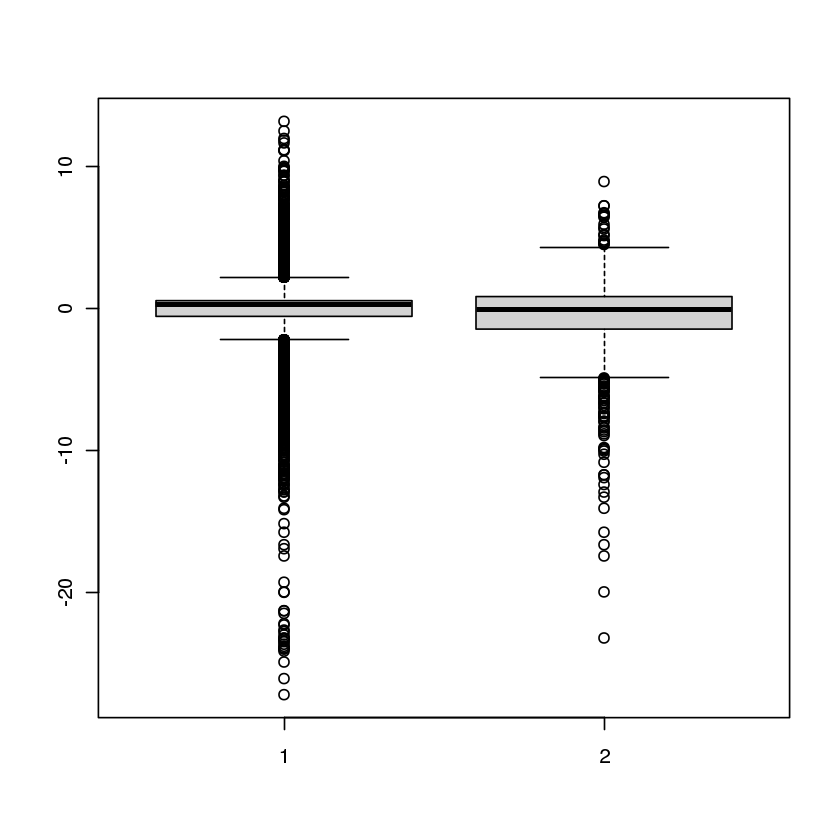

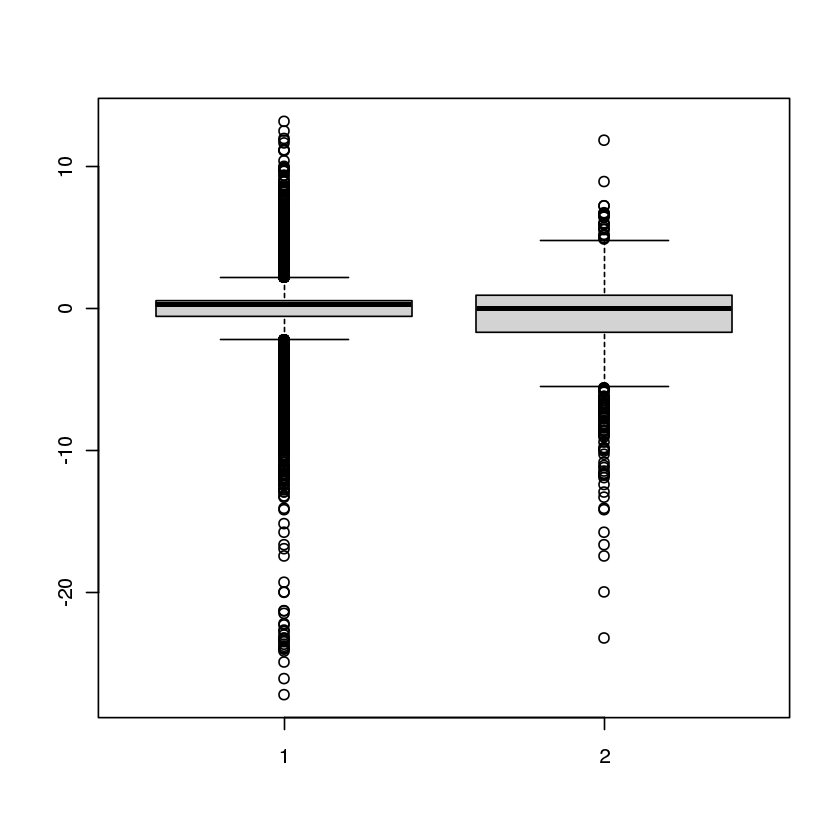

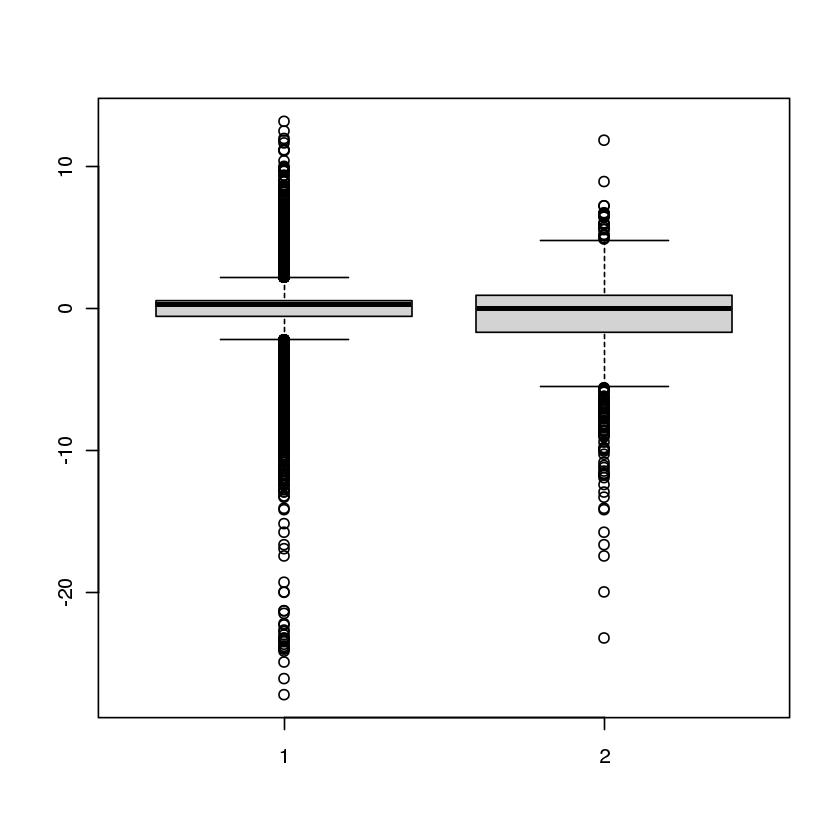

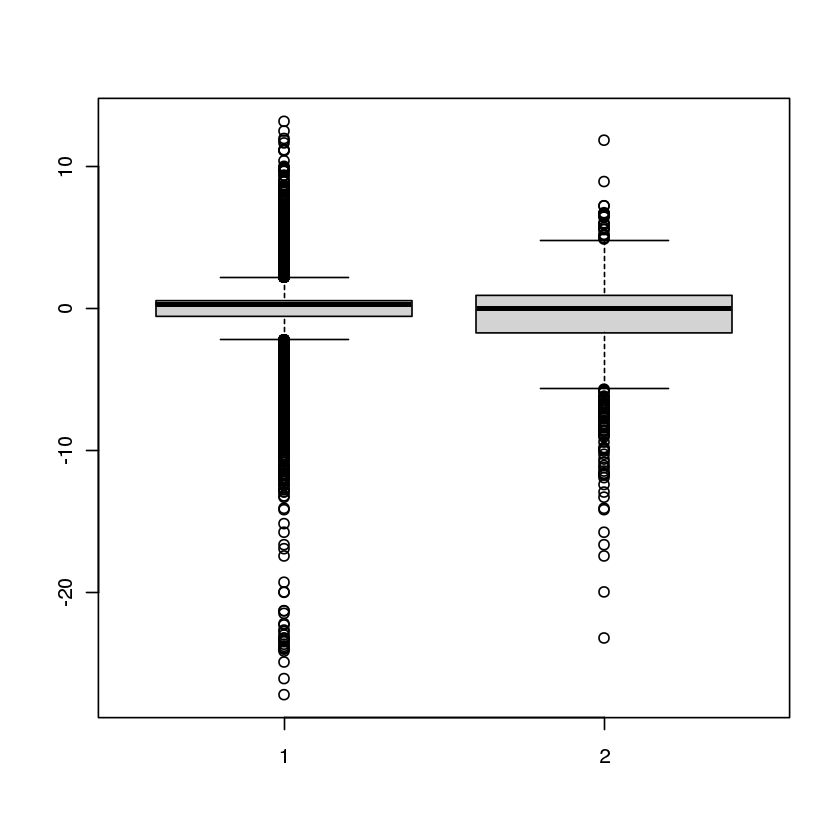

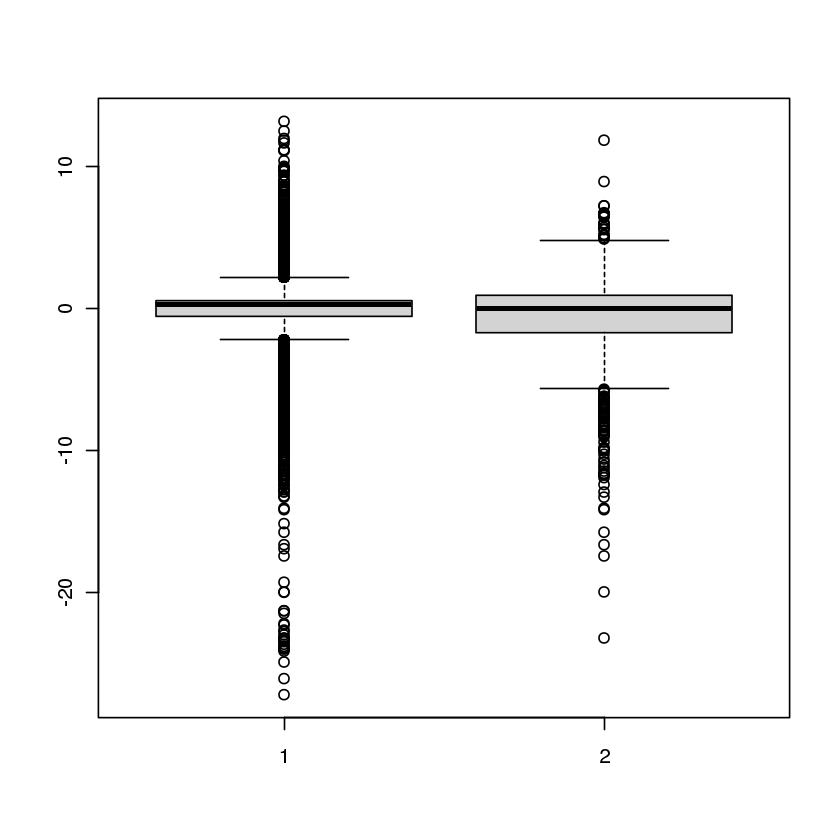

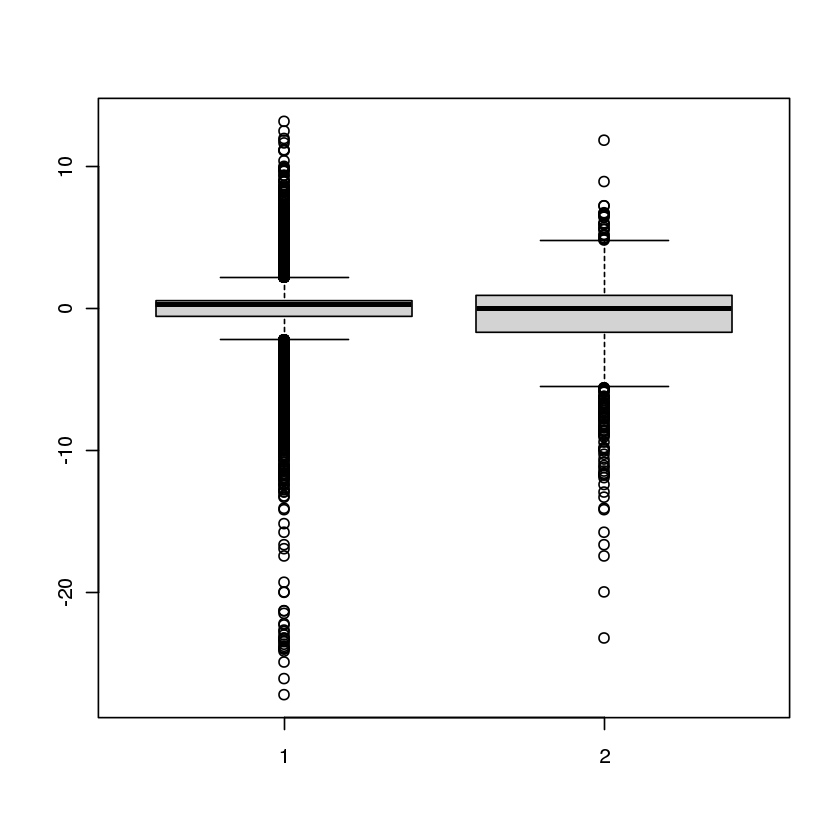

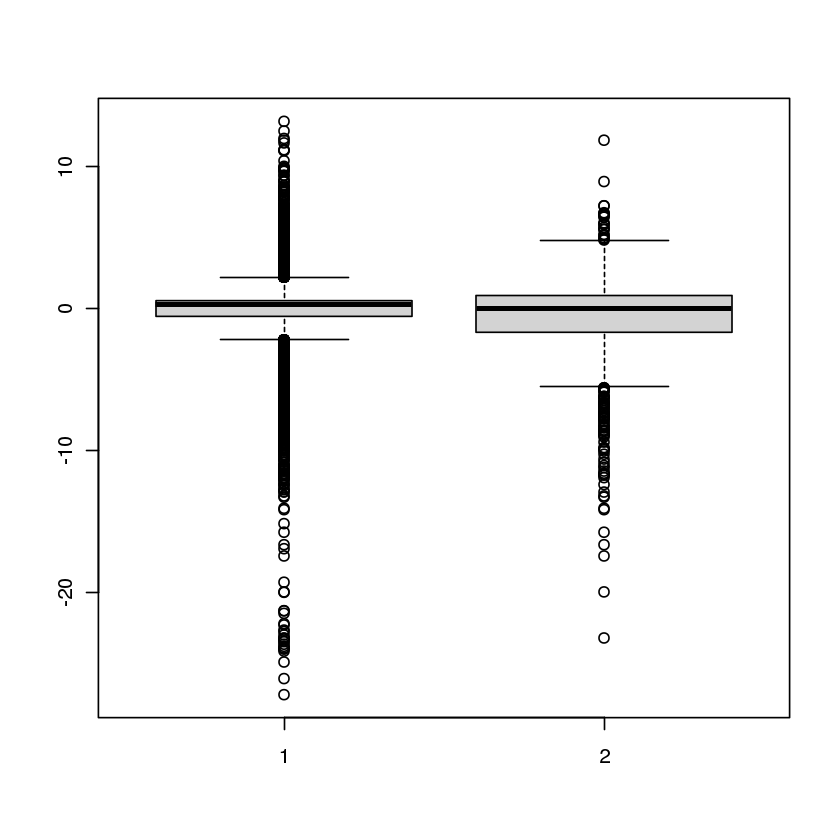

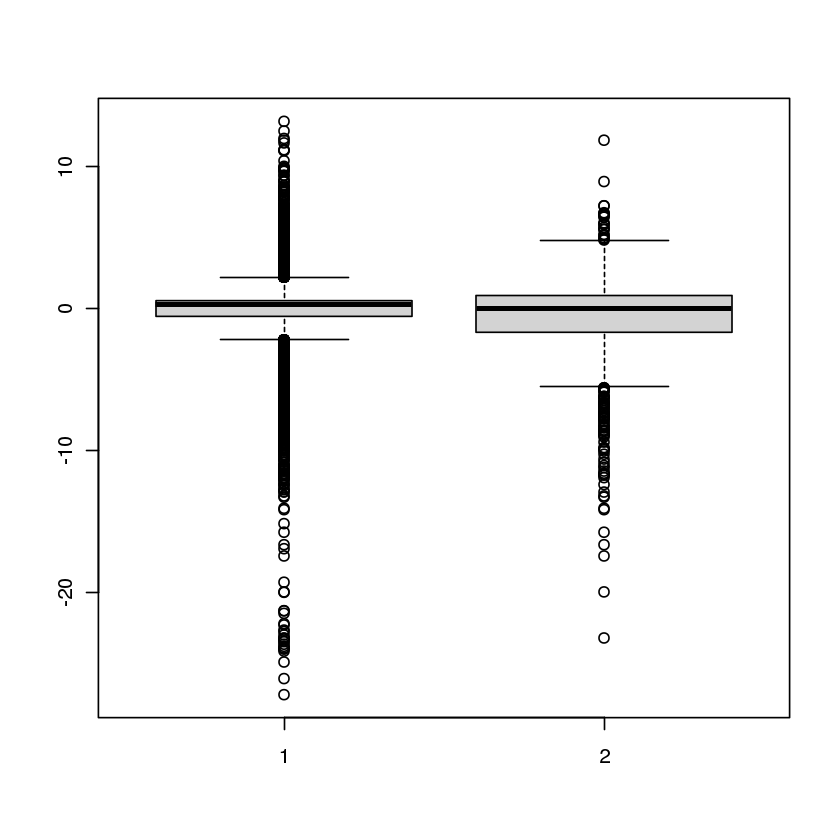

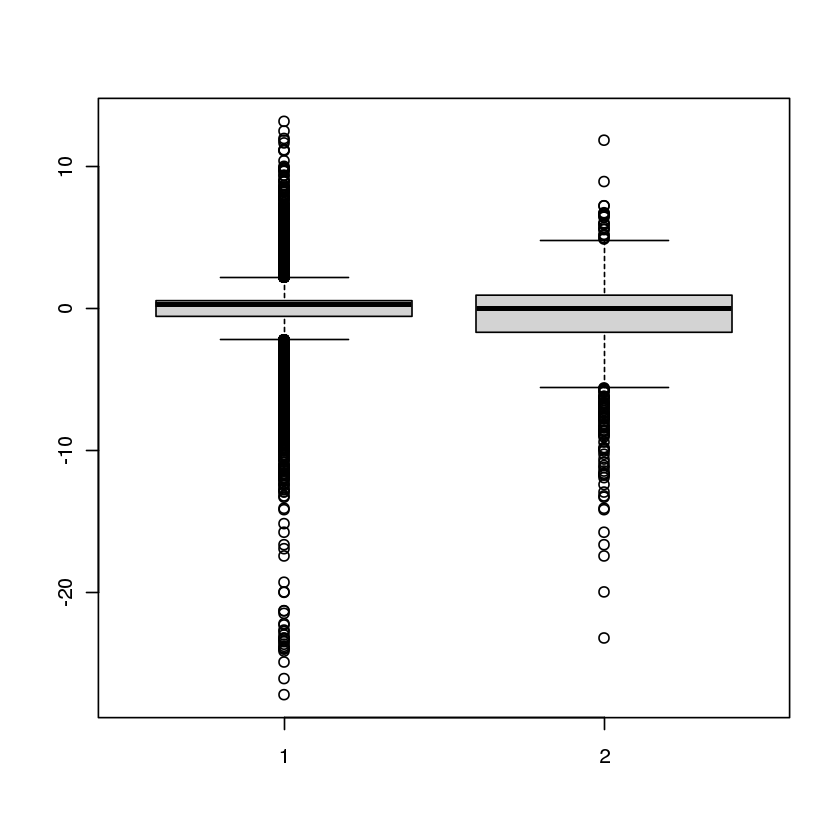

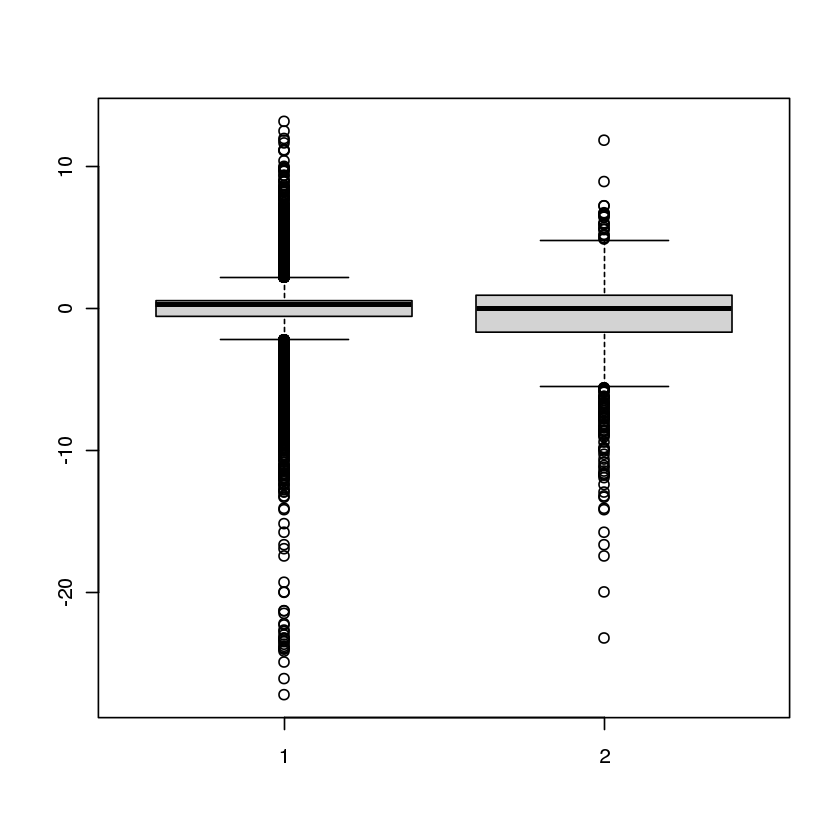

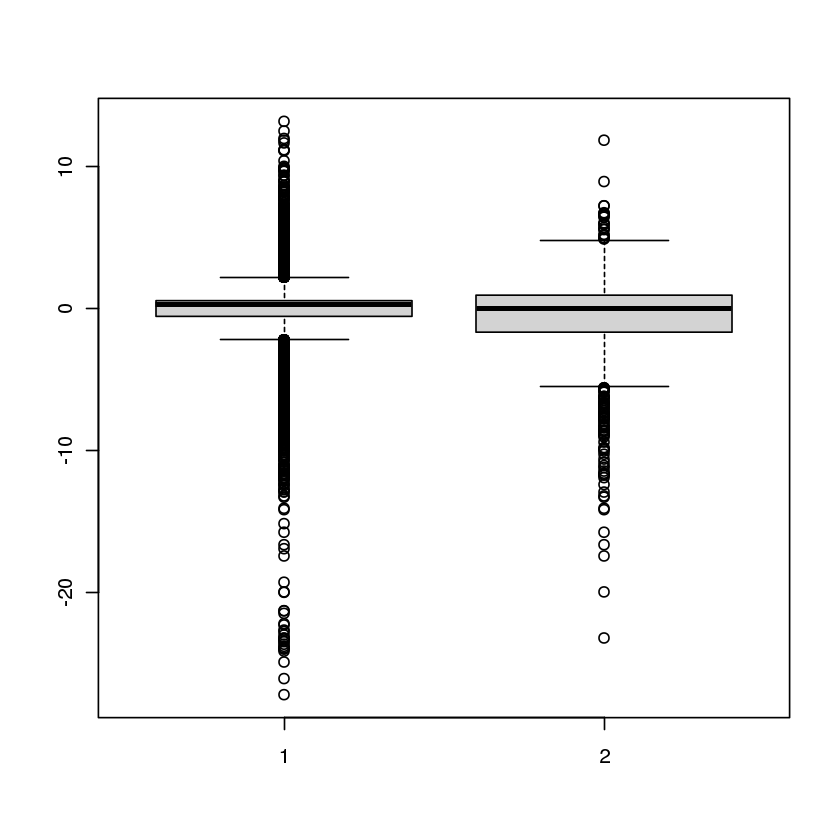

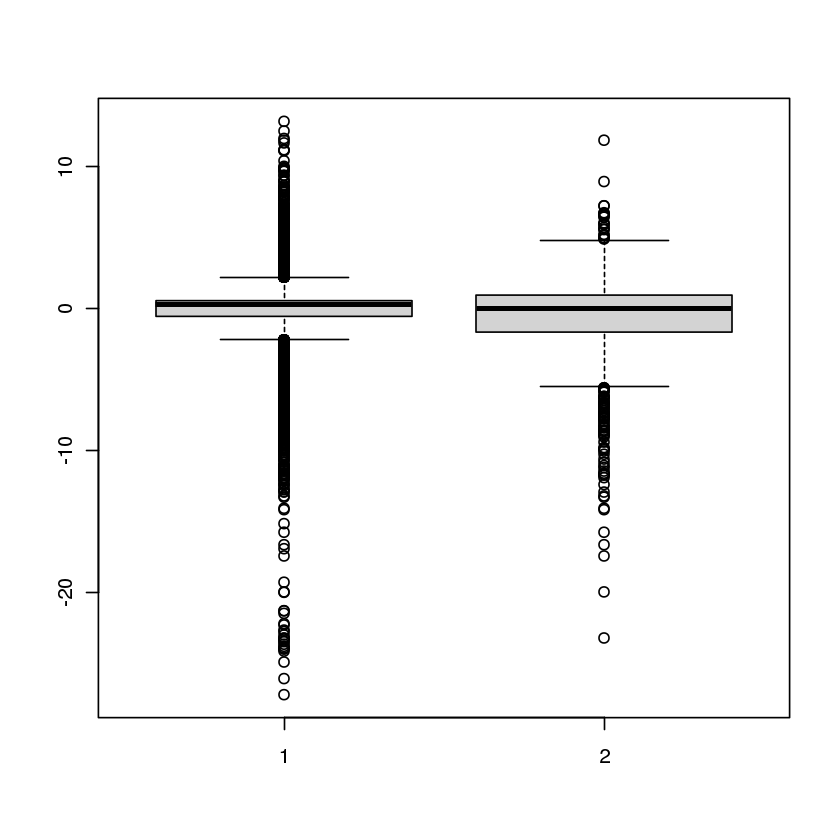

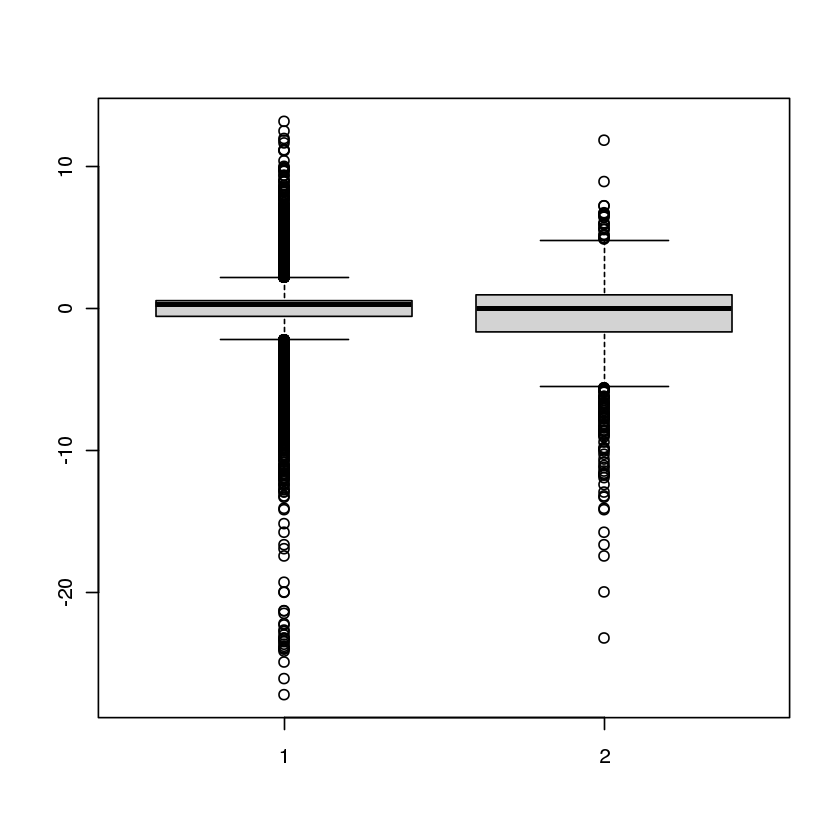

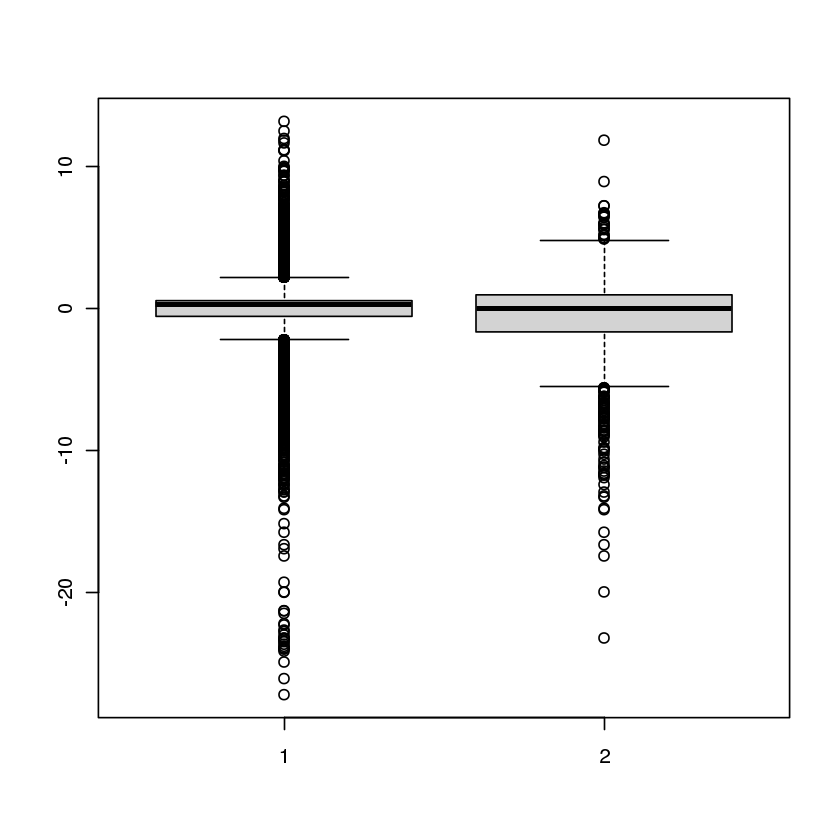

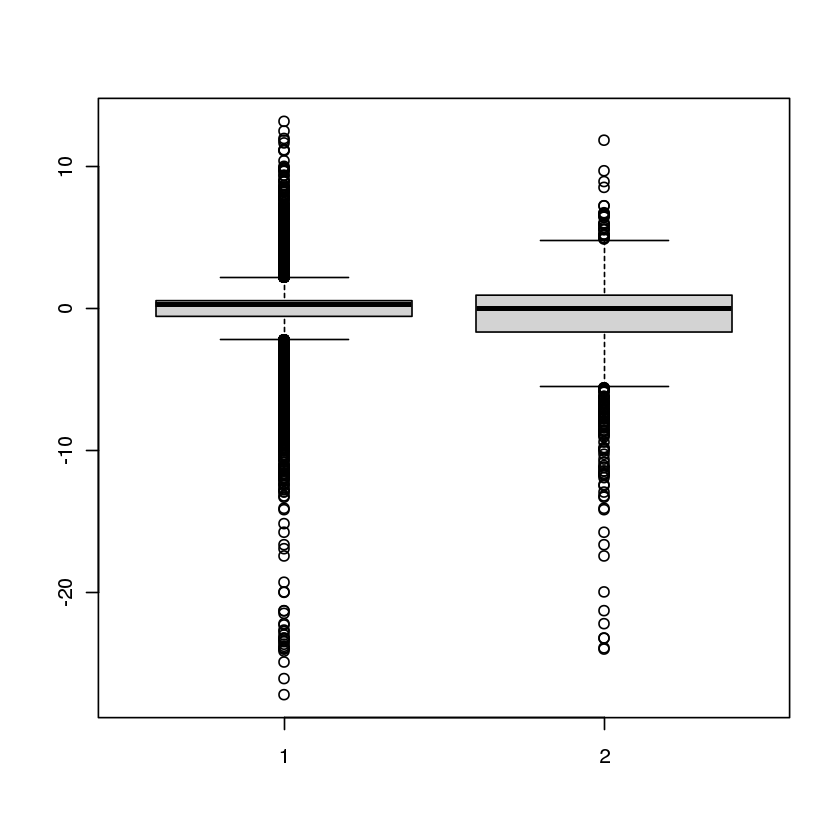

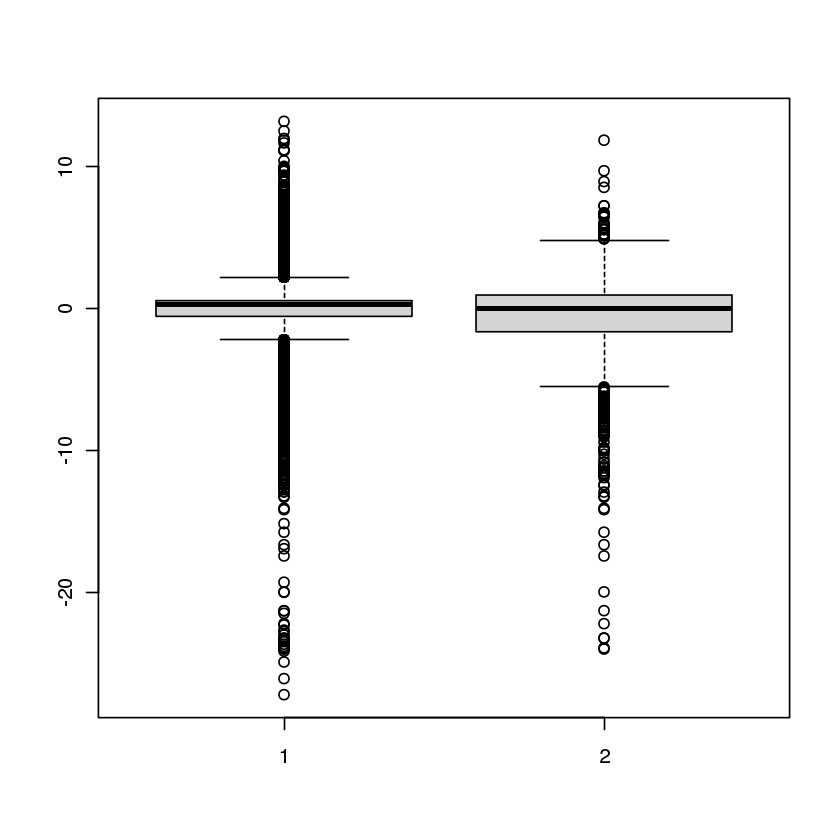

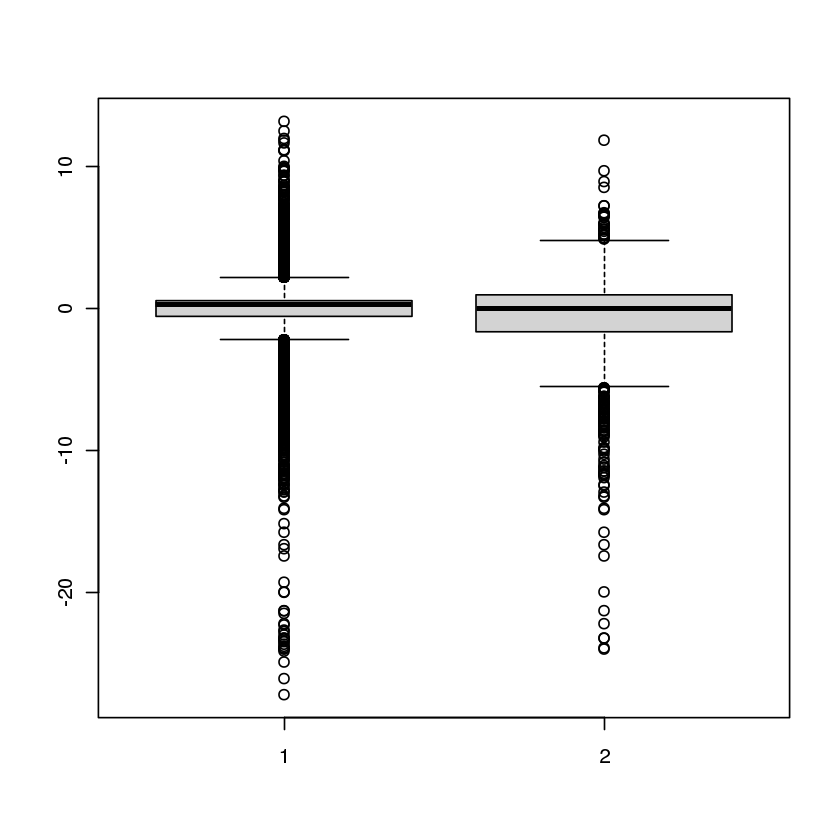

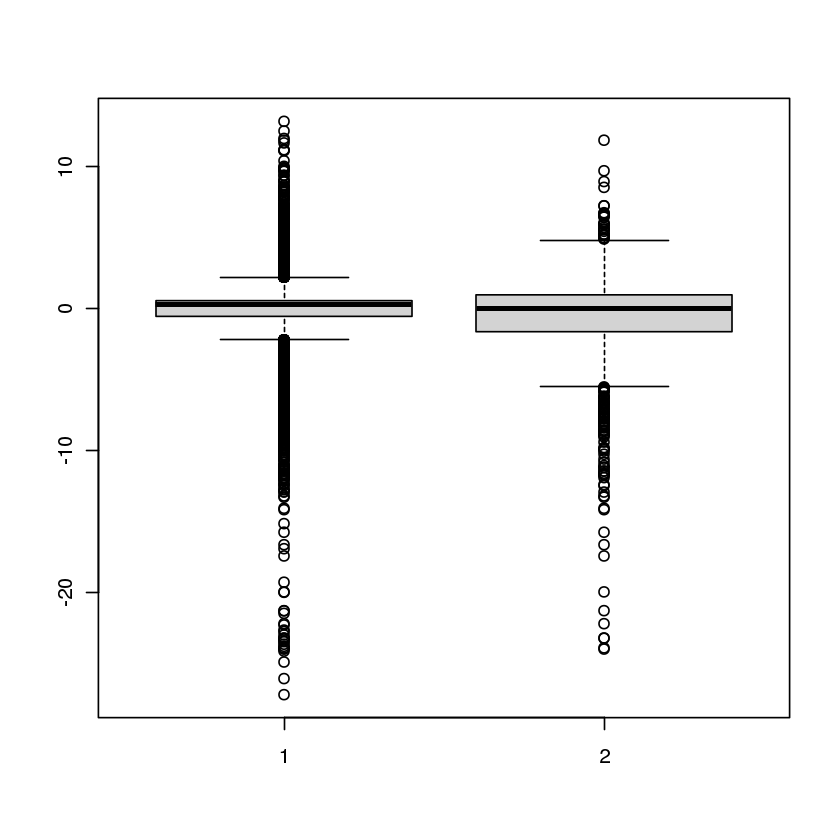

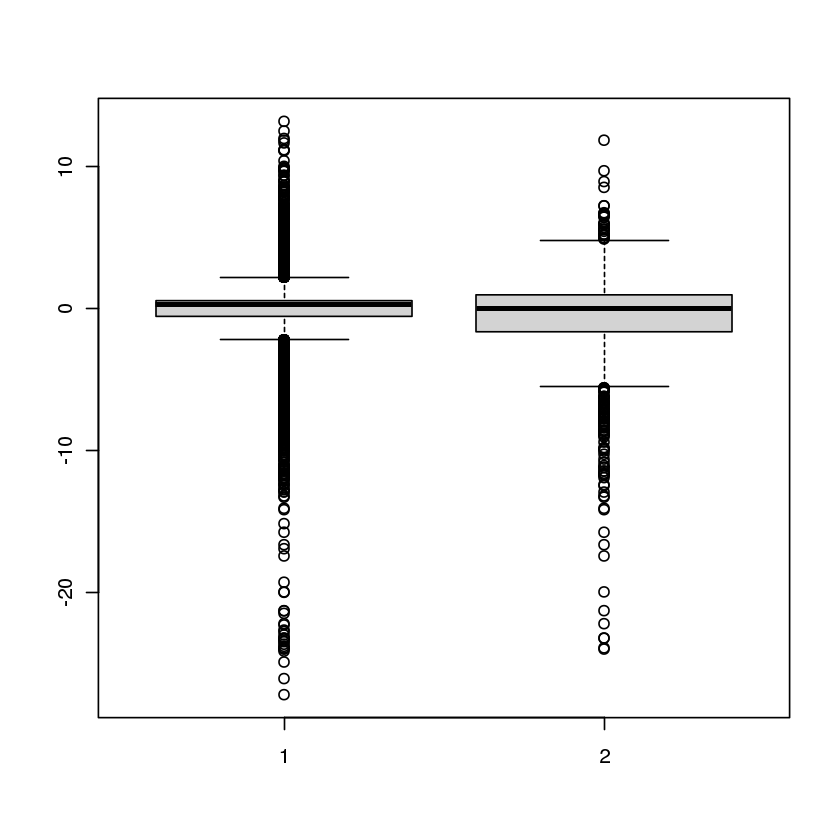

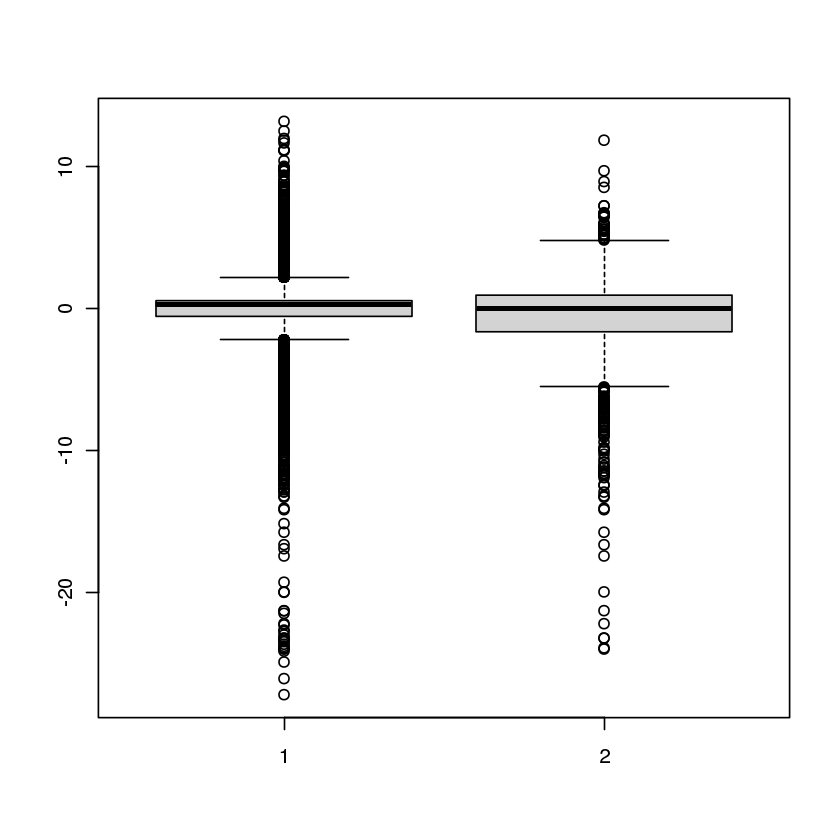

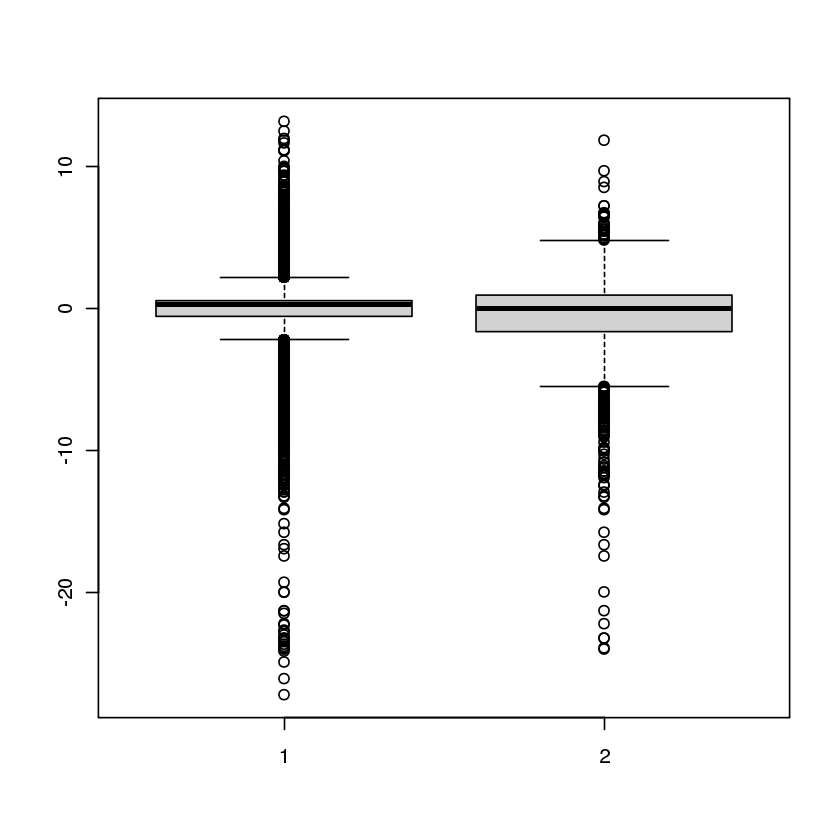

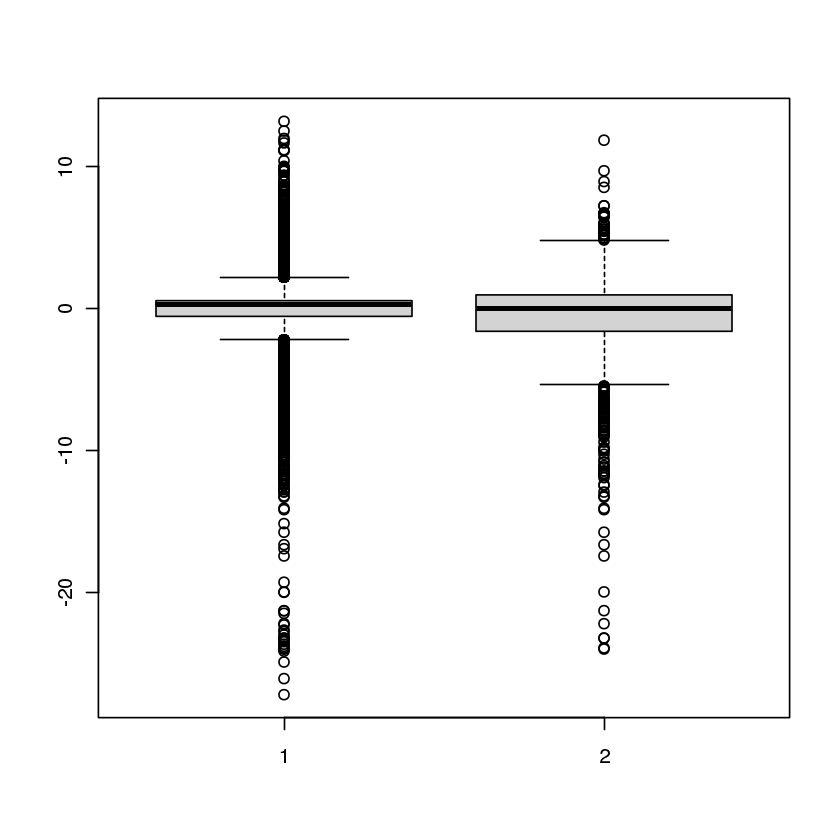

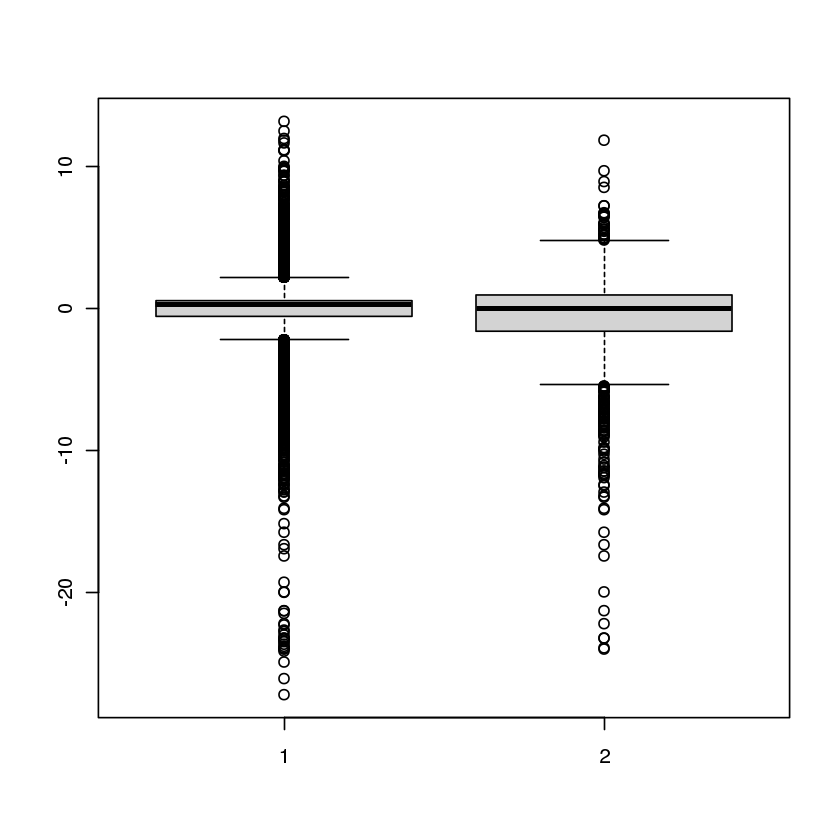

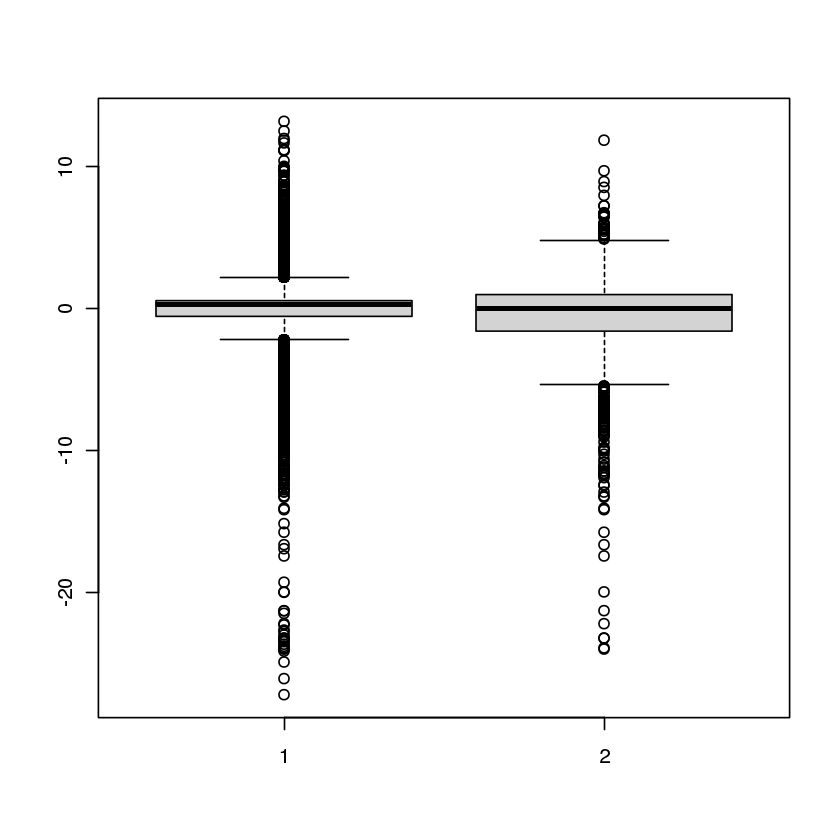

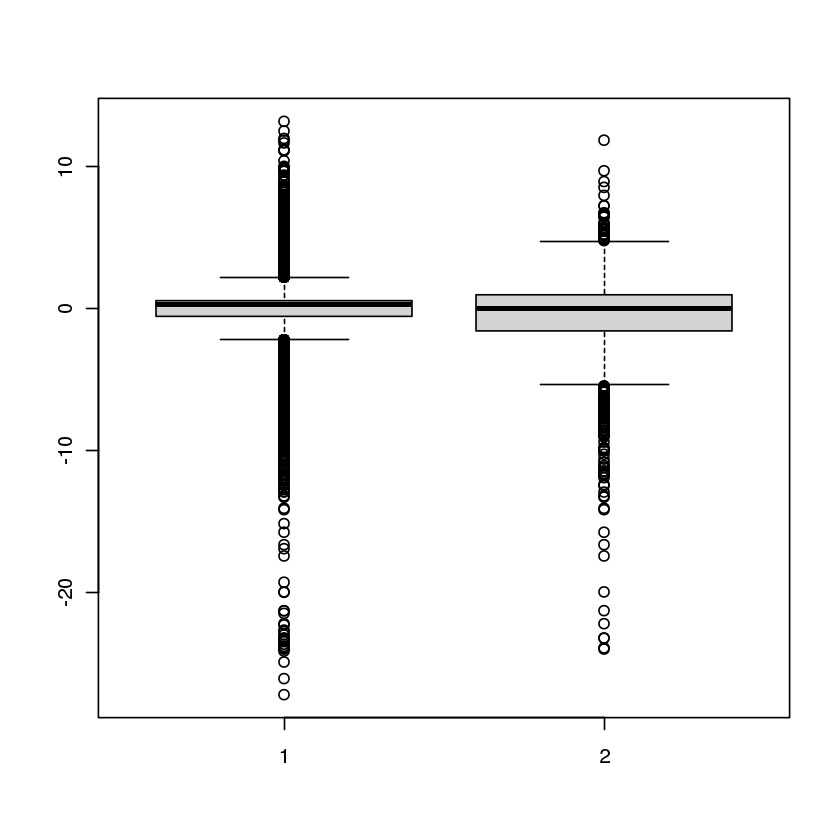

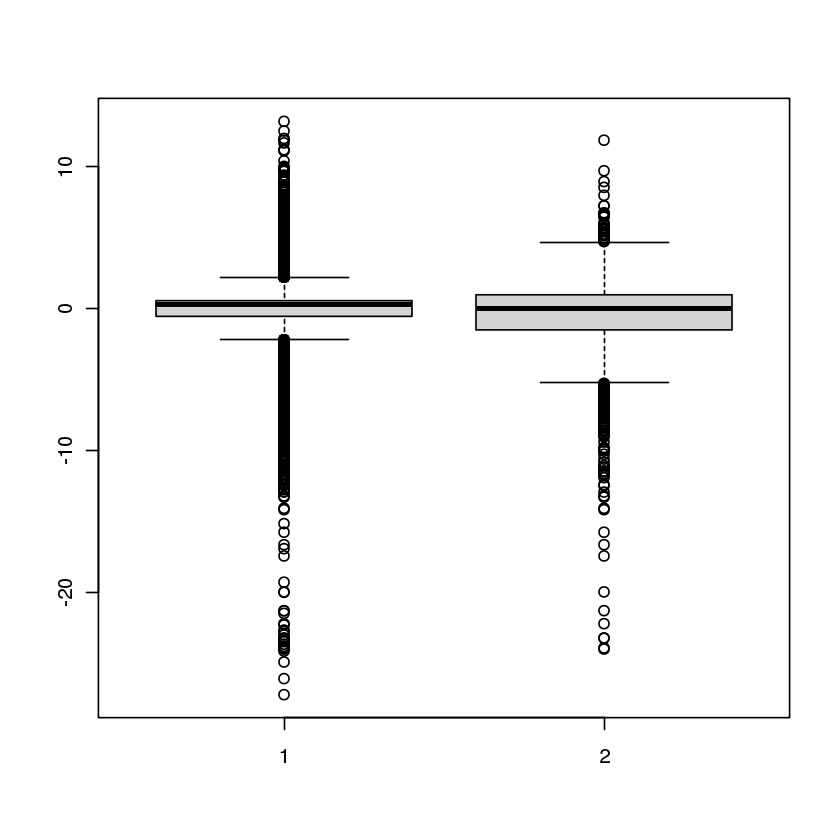

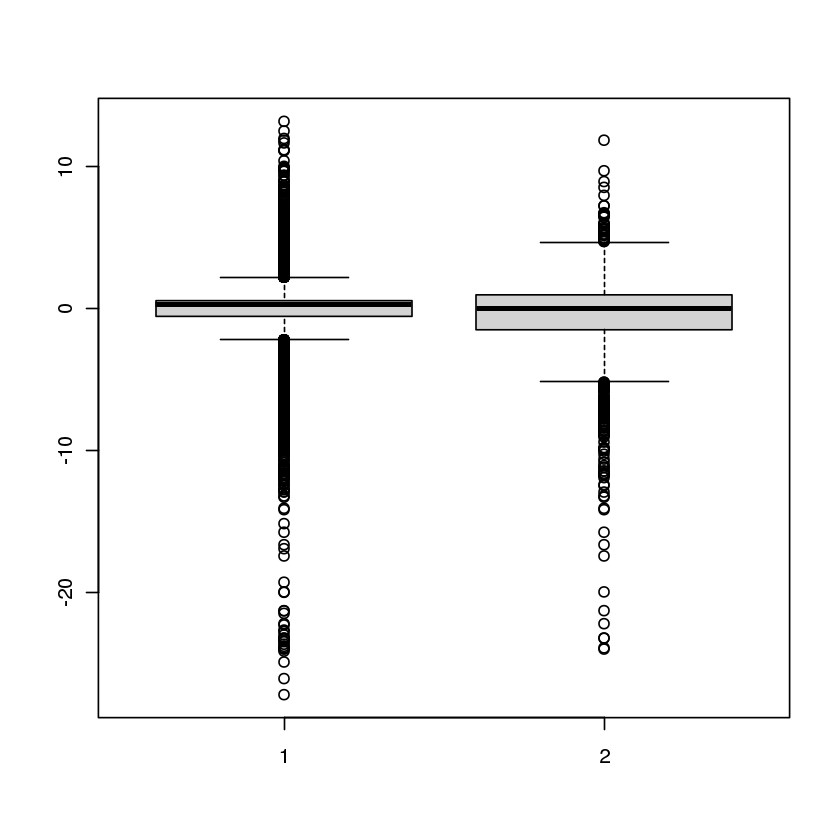

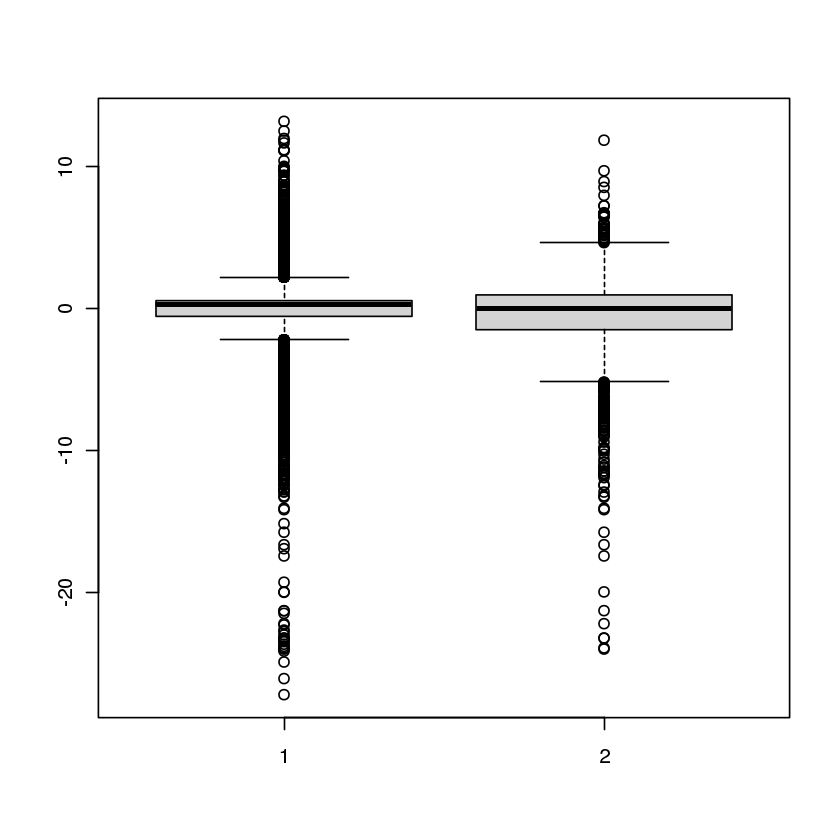

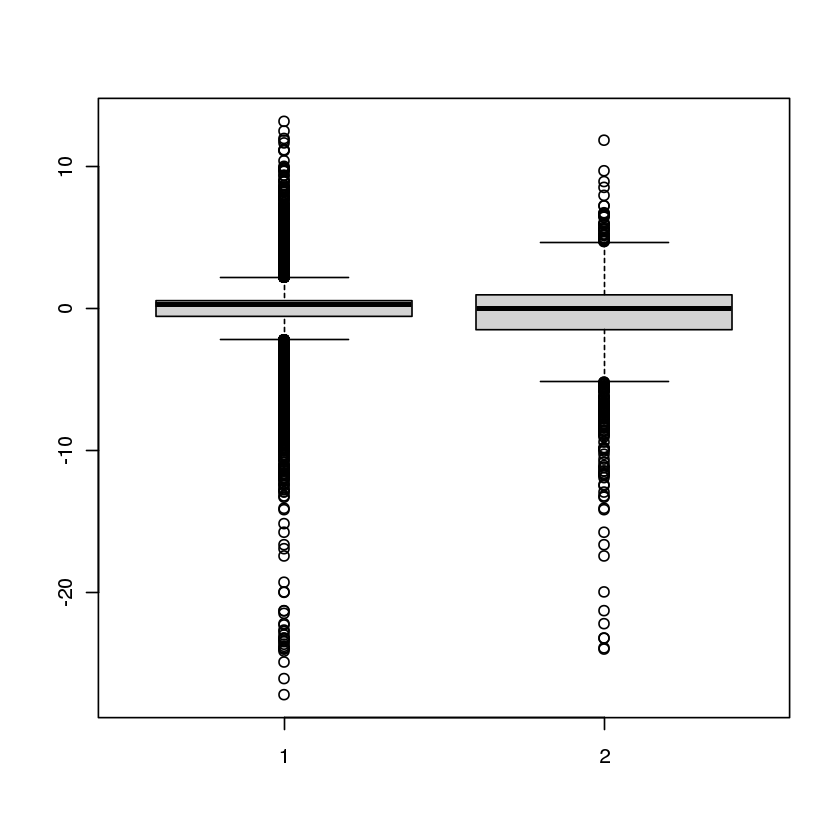

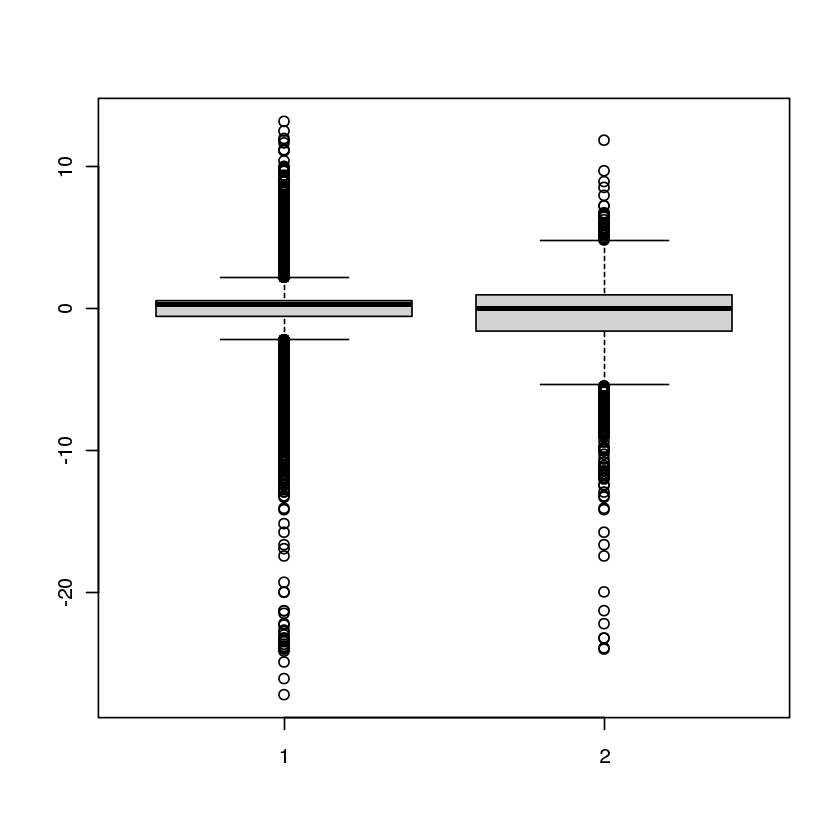

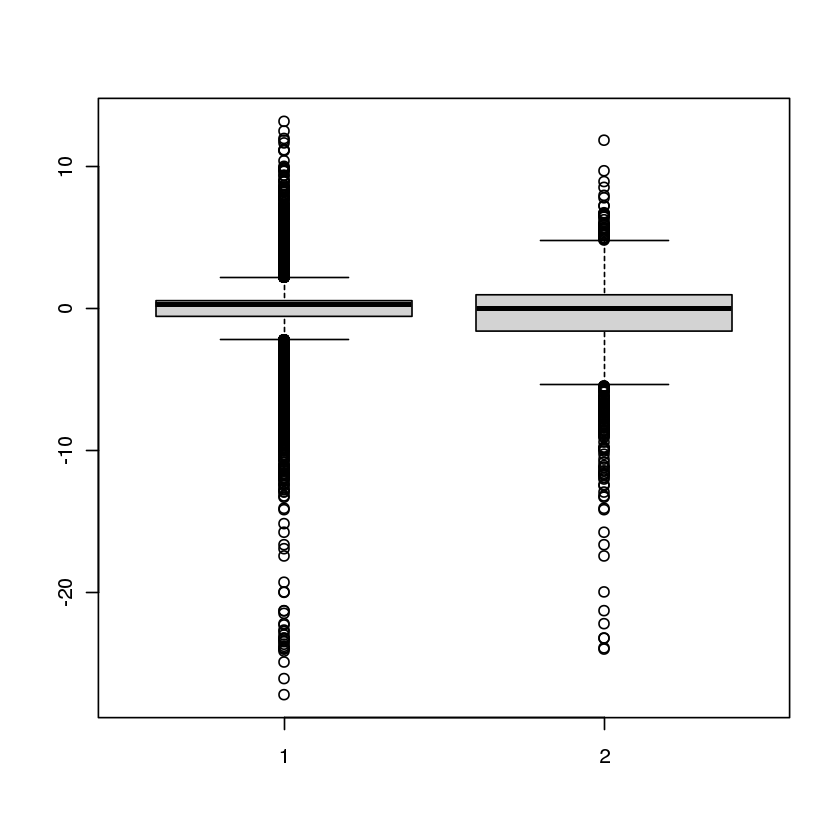

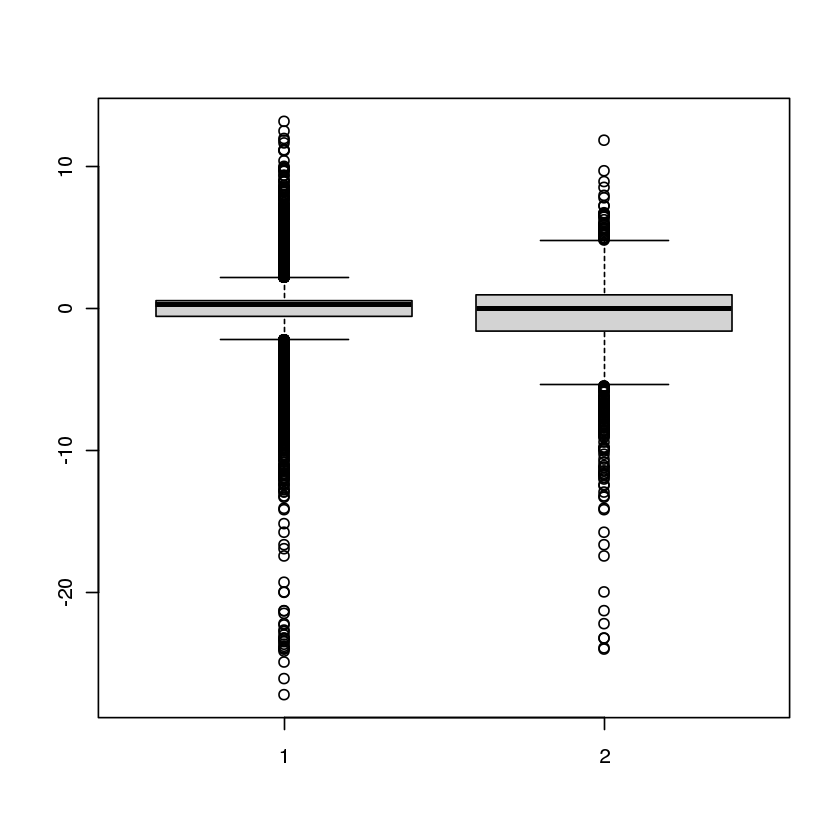

In [13]:
gene_list <- character(0)
for(i in 1:length(wound_files)) {
    current_file <- fread(paste('./wound_genes/', wound_files[i], sep=""), header=F)
    gene_list <- c(unique(append(gene_list, current_file$V1, length(gene_list))))
    ensembl_list <- getLDS(attributes=c("hgnc_symbol"), filters="hgnc_symbol",
                          values=gene_list,
                          mart=human,attributesL=c("ensembl_gene_id"),
                          martL=human)
    subset_lfc <- skin_logfc[skin_logfc$V1 %in% ensembl_list$Gene.stable.ID,]$log2FoldChange
    #print(head(subset_lfc))
    boxplot(total_lfc,subset_lfc)
}

In [7]:
skin_logfc <- data.frame(fread("skin_logfc.txt"))
total_lfc <- skin_logfc$log2FoldChange 

Warning message in fread("skin_logfc.txt"):
“Detected 6 column names but the data has 7 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
